#  Exploration of Pisa Study 2012
## by Felix Deichsel
In this project we explore the dataset of the PISA study in 2012. PISA is a survey of students' skills and knowledge as they approach the end of compulsory education. Basically the study examines

* how well students have learned the school curriculum,
* how well prepared they are for life beyond school.

Around 510,000 students in 65 economies took part in the PISA 2012 assessment of reading, mathematics and science. The dataset contains various information about the performance of students as well as their background, e.g. their social enviroment, their relationship to teachers or their personal attitude.

My goal is mainly to elaborate, which influence parents have on the performance of their kids in reading, mathematics and science. 
## Preliminary Wrangling

The first step consists data wrangling, where we prepare our data for further exploration.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import zipfile
import statsmodels.api as sm
from fitter import Fitter, get_common_distributions, get_distributions
import scipy
%matplotlib inline

Next I load the data from a .csv-file, which was downloaded [here](https://www.google.com/url?q=https://s3.amazonaws.com/udacity-hosted-downloads/ud507/pisa2012.csv.zip&sa=D&ust=1581581520574000).

In [2]:
df_raw = pd.read_csv('pisa2012.csv',encoding='latin-1')

C:\Users\deichsel\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (15,16,17,21,22,23,24,25,26,30,31,36,37,45,65,123,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,475) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


A short check will reveal, whether there are some duplicated rows, which we would delete.

In [3]:
df_raw.duplicated().sum()

0

Obviously there are no duplicated crows.

In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485490 entries, 0 to 485489
Columns: 636 entries, Unnamed: 0 to VER_STU
dtypes: float64(250), int64(18), object(368)
memory usage: 2.3+ GB


As we see, there is a total of 636 columns, which is a bit too much for us to explore completly. But as i told already, my main goal is, to evaluate the parental influence on performnaces of their kids. Thus the main features and also dependent variables are the performances of students.

I decided to restrict the examination of the data to certain areas. The first area deals with basic information about students, like where they are from and their gender. The second area covers parental attributes like education, job status and other. And of course I need the performances of the students, which is resembled by the points they achieved in math, reading and science tests.

. Thus I choose following columns:

Columns containing basic information:
* CNT,"Country code 3-character"
* OECD,"OECD country"
* ST04Q01,"Gender"
* ST03Q01,"Birth - Month"

Parents related information:
* ST11Q01,"At Home - Mother"
* ST11Q02,"At Home - Father"
* ST13Q01,"Mother<Highest Schooling>"
* ST14Q01,"Mother Qualifications - <ISCED level 6>", doctoral
* ST14Q02,"Mother Qualifications - <ISCED level 5A>", master 
* ST14Q03,"Mother Qualifications - <ISCED level 5B>", bachelor
* ST14Q04,"Mother Qualifications - <ISCED level 4>", post secondary, non tertiary education
* ST15Q01,"Mother Current Job Status"
* ST17Q01,"Father<Highest Schooling>"
* ST18Q01,"Father Qualifications - <ISCED level 6>"
* ST18Q02,"Father Qualifications - <ISCED level 5A>"
* ST18Q03,"Father Qualifications - <ISCED level 5B>"
* ST18Q04,"Father Qualifications - <ISCED level 4>"
* ST19Q01,"Father Current Job Status"
* ST20Q01,"Country of Birth International - Self"
* ST20Q02,"Country of Birth International - Mother"
* ST20Q03,"Country of Birth International - Father"
* ST57Q05,"Out-of-School Study Time - With Parent"

Performance related columns(those columns are recommended [here](https://www.oecd.org/pisa/pisaproducts/datavisualizationcontest.htm)) :
* PV1MATH: Plausible value 1 in mathematics
* PV1READ: Plausible value 1 in reading
* PV1SCIE: Plausible value 1 in science

It's time now to get the reduced dataframe, that only contains the columns of interest:

In [5]:
# Get the reduced dataframe
df = df_raw[['CNT','OECD','ST04Q01',
                 'PV1MATH','PV1READ','PV1SCIE',
                 'ST11Q01','ST11Q02',
                 'ST13Q01','ST14Q01', 'ST14Q02', 'ST14Q03','ST14Q04', 'ST15Q01',
                 'ST17Q01','ST18Q01', 'ST18Q02', 'ST18Q03','ST18Q04', 'ST19Q01',
                 'ST20Q01', 'ST20Q02', 'ST20Q03',
                 'ST57Q05'
                 ]]

To achieve better readability I rename the columns so the meaning of each column is clear.

In [6]:
# Build dictionary, that contains old and new names
dic_rename = {
    'CNT' : 'country',
    'OECD' : 'is_oecd_country',
    'ST04Q01' : 'gender',
    
    'ST11Q01' : "at_home_mother",
    'ST11Q02' : "at_home_father",
    'ST13Q01' : "mother_school",
    'ST14Q01' : "mother_ISCED_6",
    'ST14Q02' : "mother_ISCED_5A",
    'ST14Q03' : "mother_ISCED_5B",
    'ST14Q04' : "mother_ISCED_4",
    'ST15Q01' : "mother_job_status",
    'ST17Q01' : "father_school",
    'ST18Q01' : "father_ISCED_6",
    'ST18Q02' : "father_ISCED_5A",
    'ST18Q03' : "father_ISCED_5B",
    'ST18Q04' : "father_ISCED_4",
    'ST19Q01' : "father_job_status",
    'ST20Q01' : "self_birth_country_international",
    'ST20Q02' : "mother_birth_country_international",
    'ST20Q03' : "father_birth_country_international",
    'ST57Q05' : "lessons_with_Parent",

    'PV1MATH' : 'math_score',
    'PV1READ' : 'read_score',
    'PV1SCIE' : 'sci_score' 
}

In [7]:
df = df.rename(columns = dic_rename)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485490 entries, 0 to 485489
Data columns (total 24 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   country                             485490 non-null  object 
 1   is_oecd_country                     485490 non-null  object 
 2   gender                              485490 non-null  object 
 3   math_score                          485490 non-null  float64
 4   read_score                          485490 non-null  float64
 5   sci_score                           485490 non-null  float64
 6   at_home_mother                      460559 non-null  object 
 7   at_home_father                      441036 non-null  object 
 8   mother_school                       457979 non-null  object 
 9   mother_ISCED_6                      390481 non-null  object 
 10  mother_ISCED_5A                     407641 non-null  object 
 11  mother_ISCED_5B           

In [9]:
df.isnull().sum()

country                                    0
is_oecd_country                            0
gender                                     0
math_score                                 0
read_score                                 0
sci_score                                  0
at_home_mother                         24931
at_home_father                         44454
mother_school                          27511
mother_ISCED_6                         95009
mother_ISCED_5A                        77849
mother_ISCED_5B                       103049
mother_ISCED_4                        181275
mother_job_status                      17739
father_school                          42229
father_ISCED_6                        114075
father_ISCED_5A                        97694
father_ISCED_5B                       122656
father_ISCED_4                        193397
father_job_status                      34080
self_birth_country_international        9127
mother_birth_country_international     12972
father_bir

The reduced dataset, we are working with, has 34 columns and 485490 rows. 
* Rows 1-7 have no missing values. They include basic information about the students as well as the test results
* The other rows all have missing vaues
* The columns, that describe the education of a parent, can be condensed to one single column. This column will contain the single highest education stage. That column we be of type ordered categroical.
 
* Following columns will need a conversion from type object to categorical
    * OECD
    * Country
    * Gender
    * Mother/father at home
    * Mother/father job status
    * Self, mother, father birth country

I start with condensing the educational information of each parent. First we get a column, that only contains the non school education.

In [10]:
# Add column, that contains only the highest non school education
m4 = df['mother_ISCED_4'] == 'Yes'
m5B = df['mother_ISCED_5B'] == 'Yes'
m5A = df['mother_ISCED_5A'] == 'Yes'
m6 = df['mother_ISCED_6'] == 'Yes'
df['mother_highest_non_school_edu'] = "0"
df['mother_highest_non_school_edu'] = df['mother_highest_non_school_edu'].where(~m4,'4')
df['mother_highest_non_school_edu'] = df['mother_highest_non_school_edu'].where(~m5B,'5B')
df['mother_highest_non_school_edu'] = df['mother_highest_non_school_edu'].where(~m5A,'5A')
df['mother_highest_non_school_edu'] = df['mother_highest_non_school_edu'].where(~m6,'6')

m4 = df['father_ISCED_4'] == 'Yes'
m5B = df['father_ISCED_5B'] == 'Yes'
m5A = df['father_ISCED_5A'] == 'Yes'
m6 = df['father_ISCED_6'] == 'Yes'
df['father_highest_non_school_edu'] = "0"
df['father_highest_non_school_edu'] = df['father_highest_non_school_edu'].where(~m4,'4')
df['father_highest_non_school_edu'] = df['father_highest_non_school_edu'].where(~m5B,'5B')
df['father_highest_non_school_edu'] = df['father_highest_non_school_edu'].where(~m5A,'5A')
df['father_highest_non_school_edu'] = df['father_highest_non_school_edu'].where(~m6,'6')

Before we merge this columns with the school education columns to a overall highest education column, we will rename the values in the school education column.

In [11]:
#Create columns, that contains short form of highest school education of mother and father
df['mother_highest_school_edu'] = df.mother_school.replace(regex= r'.*level 3A.*', value = '3A')
df.mother_highest_school_edu.replace(regex= r'.*3B.*', value = '3BC', inplace = True)
df.mother_highest_school_edu.replace(regex= r'.*2.*', value = '2', inplace = True)
df.mother_highest_school_edu.replace(regex= r'.*She did.*', value = '0', inplace = True)
df.mother_highest_school_edu.replace(regex= r'.*1.*', value = '1', inplace = True)

df['father_highest_school_edu'] = df.father_school.replace(regex= r'.*level 3A.*', value = '3A')
df.father_highest_school_edu.replace(regex= r'.*3B.*', value = '3BC', inplace = True)
df.father_highest_school_edu.replace(regex= r'.*2.*', value = '2', inplace = True)
df.father_highest_school_edu.replace(regex= r'.*He did.*', value = '0', inplace = True)
df.father_highest_school_edu.replace(regex= r'.*1.*', value = '1', inplace = True)

Now I merge the columns with the highest scholl education and the highest non school education to one column, that contains the highest overall education.

In [12]:
# Create column that contains highest overall education of the mother
m = df.mother_highest_non_school_edu == '0'
df['mother_highest_overall_edu'] = df.mother_highest_school_edu.where(m,df.mother_highest_non_school_edu)
df['mother_highest_overall_edu'].value_counts()

5A     89389
3A     77388
5B     68219
2      66650
4      49380
1      36556
3BC    35672
6      25063
0      18768
Name: mother_highest_overall_edu, dtype: int64

In [13]:
# Create column that contains highest overall education of the father
m = df.father_highest_non_school_edu == '0'
df['father_highest_overall_edu'] = df.father_highest_school_edu.where(m,df.father_highest_non_school_edu)
df['father_highest_overall_edu'].value_counts()

5A     83817
3A     67718
2      66728
5B     61617
4      51172
3BC    39789
1      35938
6      29589
0      16535
Name: father_highest_overall_edu, dtype: int64

Now we got for mother and father a column, that contains their highest educational level. Since those columns are still of type <object>, we will change that to ordered categorical type.

In [120]:
# Change column type to ordered category
ordinal_edu_values = pd.CategoricalDtype(categories=['0','1','2', '3BC','3A', '4','5B','5A','6'], ordered = True)
df['mother_highest_overall_edu'] = df['mother_highest_overall_edu'].astype(ordinal_edu_values)
df['father_highest_overall_edu'] = df['father_highest_overall_edu'].astype(ordinal_edu_values);
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389081 entries, 0 to 389080
Data columns (total 17 columns):
 #   Column                              Non-Null Count   Dtype   
---  ------                              --------------   -----   
 0   country                             389081 non-null  object  
 1   is_oecd_country                     389081 non-null  object  
 2   gender                              389081 non-null  object  
 3   math_score                          389081 non-null  float64 
 4   read_score                          389081 non-null  float64 
 5   sci_score                           389081 non-null  float64 
 6   at_home_mother                      389081 non-null  object  
 7   at_home_father                      389081 non-null  object  
 8   mother_job_status                   389081 non-null  object  
 9   father_job_status                   389081 non-null  object  
 10  self_birth_country_international    389081 non-null  object  
 11  mother_birth_

I discovered also, that the values of mother_job_status and father_job_status posses spaces at the end, which i will remove now.

In [15]:
#Strip traling and leading spaces
df.mother_job_status = df.mother_job_status.str.strip()
df.father_job_status = df.father_job_status.str.strip()

Its time now to drop all columns besides those two, that contain inforamtion to the educational level of parents.

In [16]:
#Drop rows with that contain NA
df.drop(['mother_school','mother_ISCED_6','mother_ISCED_5A','mother_ISCED_5B', 'mother_ISCED_4',
        'father_school','father_ISCED_6','father_ISCED_5A','father_ISCED_5B', 'father_ISCED_4', 
        'mother_highest_non_school_edu','father_highest_non_school_edu',
        'mother_highest_school_edu','father_highest_school_edu'], axis = 1, inplace=True);
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485490 entries, 0 to 485489
Data columns (total 16 columns):
 #   Column                              Non-Null Count   Dtype   
---  ------                              --------------   -----   
 0   country                             485490 non-null  object  
 1   is_oecd_country                     485490 non-null  object  
 2   gender                              485490 non-null  object  
 3   math_score                          485490 non-null  float64 
 4   read_score                          485490 non-null  float64 
 5   sci_score                           485490 non-null  float64 
 6   at_home_mother                      460559 non-null  object  
 7   at_home_father                      441036 non-null  object  
 8   mother_job_status                   467751 non-null  object  
 9   father_job_status                   451410 non-null  object  
 10  self_birth_country_international    476363 non-null  object  
 11  mother_birth_

Now I change the remaining columns, that are listed above, to data type category

In [17]:
#Change column type to <category>
categrical_column_names = ['country' , 'is_oecd_country', 'gender','at_home_mother','at_home_father', 'mother_job_status','father_job_status',
                     'self_birth_country_international','mother_birth_country_international', 'father_birth_country_international']
for name in categrical_column_names:
    df[name] = df[name].astype('category')

In [18]:
df.isna().sum()

country                                    0
is_oecd_country                            0
gender                                     0
math_score                                 0
read_score                                 0
sci_score                                  0
at_home_mother                         24931
at_home_father                         44454
mother_job_status                      17739
father_job_status                      34080
self_birth_country_international        9127
mother_birth_country_international     12972
father_birth_country_international     16349
lessons_with_Parent                   195988
mother_highest_overall_edu             18405
father_highest_overall_edu             32587
dtype: int64

Obviously, we got a lot of missing values in the lessons_with_parent column. I will take this into account, when I evalutate those columns. The othter columns look quite dense, thus i will drop all rows which have a nan entry in those Columns.txt

In [19]:
df.dropna(subset = ['at_home_mother', 'at_home_father', 'mother_job_status','father_job_status',
                    'self_birth_country_international', 'mother_birth_country_international',
                    'father_birth_country_international', 'mother_highest_overall_edu', 'father_highest_overall_edu'
                    ], inplace=True)

Last but not least, i want a column, that represents the combined performance of a student in all three areas. 

In [20]:
df['combined_score'] = df['math_score'] + df['read_score'] + df['sci_score']

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389081 entries, 0 to 485489
Data columns (total 17 columns):
 #   Column                              Non-Null Count   Dtype   
---  ------                              --------------   -----   
 0   country                             389081 non-null  category
 1   is_oecd_country                     389081 non-null  category
 2   gender                              389081 non-null  category
 3   math_score                          389081 non-null  float64 
 4   read_score                          389081 non-null  float64 
 5   sci_score                           389081 non-null  float64 
 6   at_home_mother                      389081 non-null  category
 7   at_home_father                      389081 non-null  category
 8   mother_job_status                   389081 non-null  category
 9   father_job_status                   389081 non-null  category
 10  self_birth_country_international    389081 non-null  category
 11  mother_birth_

In [22]:
df.to_csv('pisa_reduced', index=False)

Now the dataset looks good for further investigation.

### Main features of interest in the dataset

The main features are clearly the scores in math, reading, science and the combined score. We want to identify factors, that have the biggest influence on those performaces. 

### Structure of the dataset

The dataset consists of 17 columns. Of those are:
* 2 datatype _ordered category_ (highest education overall of mother/father)
* 5 datatype _float64_ (4 score columns and 1 lessons with parent column)
* 10 data _category_ (columns giving information about country, OECD status, whether parents are at home, job status and birth country)



### Expectation
I expect, that the biggest influence will be the education level of parents, because good education should have have two positive effects: First is, that often parents with a good education know about the importance of a good education for further live and thus try to support and promote their children more. Another effect could be, that a good education is often associated with high paid jobs and wealth. Thus well educated parents can afford tutoring for their children or schools with better reputation.

I also inspect, that the performance of students in OECD countries will be better. One reason is as before, that those countries are wealthier the other is, that those the PISA test was developed for OECD countries and thus test knowledge, that is relevant in those countries. 

In terms of country of birth, students performnaces should be worse, if the student himself or his parents are not born in the country of the test. Main reason for this is the possible language difference. I also expect, that the performance drop in reading will be greater than in math or science.

The influence of parents beeing at home should be positive on the students performance, because parents at home can care. However it would be interesting, what happens, when both parents are jobless and thats the reason for beeing at home.

Finally I expect the job status having a positive effect, if at least one parent is working full time and earns enough money, to provide a certain level of wealth.

## Univariate Exploration

First we load the saved dataframe

In [23]:
df = pd.read_csv('pisa_reduced')

I will start with the distribution of the main variables. Those are the performances of all students in math, reading and science.

In [24]:
df.math_score.max(), df.sci_score.max(), df.read_score.max()

(962.2293, 903.3383, 904.8026)

In [25]:
df.math_score.min(), df.sci_score.min(), df.read_score.min()

(71.1248, 6.8445, 0.0834)

In [26]:
bins1 = np.arange(0,1000, 25)
bins2 = np.arange(0,3000,75)

C:\Users\deichsel\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\deichsel\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\deichsel\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

Text(0.5, 0, 'Score')

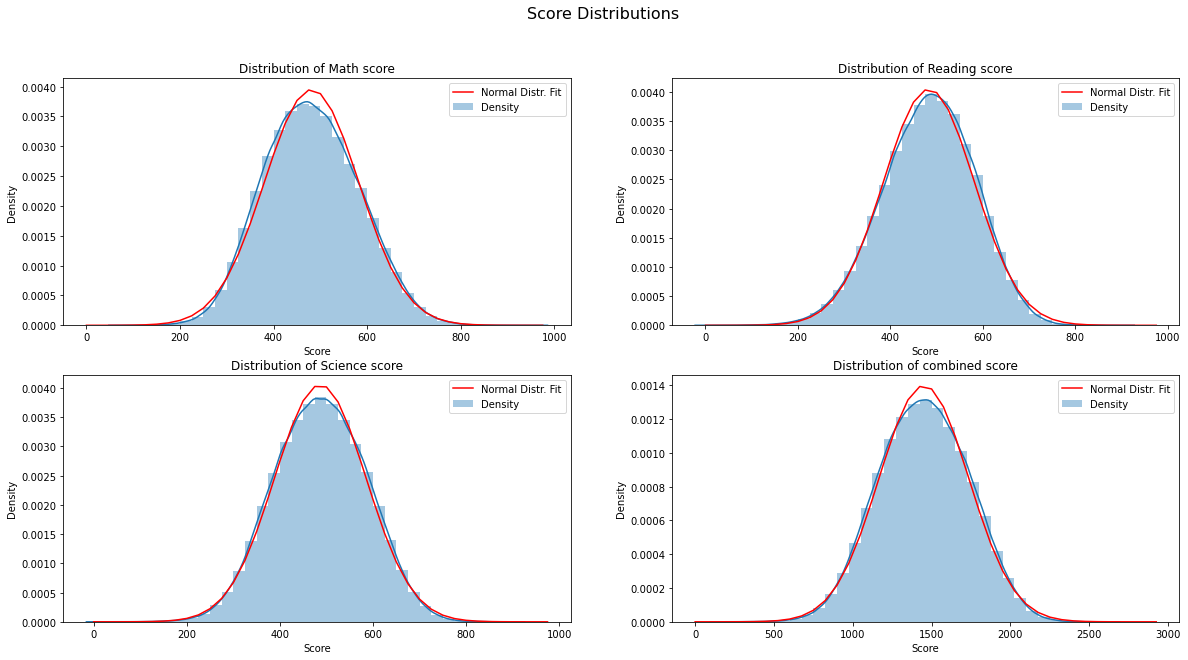

In [261]:
# Plot the score distributions in math, reading, science and combined
fitg = plt.figure(figsize = [20,10])
plt.suptitle('Score Distributions', fontsize = 16)

ax1 = plt.subplot(2,2,1)
mean, var = scipy.stats.distributions.norm.fit(df.math_score)
sb.distplot(df.math_score, bins = bins1, label = 'Density')
fitted_data = scipy.stats.distributions.norm.pdf(bins1, mean, var)
ax1.plot(bins1, fitted_data, 'r-', label = 'Normal Distr. Fit')
ax1.legend()
ax1.set_title('Distribution of Math score', fontsize = 12)
ax1.set_xlabel('Score')

ax2 = plt.subplot(2,2,2)
mean, var = scipy.stats.distributions.norm.fit(df.read_score)
sb.distplot(df.read_score, bins = bins1, label = 'Density')
fitted_data = scipy.stats.distributions.norm.pdf(bins1, mean, var)
ax2.plot(bins1, fitted_data, 'r-', label = 'Normal Distr. Fit')
ax2.legend()
ax2.set_title('Distribution of Reading score', fontsize = 12)
ax2.set_xlabel('Score')

ax3 = plt.subplot(2,2,3)
mean, var = scipy.stats.distributions.norm.fit(df.sci_score)
sb.distplot(df.sci_score, bins = bins1, label = 'Density')
fitted_data = scipy.stats.distributions.norm.pdf(bins1, mean, var)
ax3.plot(bins1, fitted_data, 'r-', label = 'Normal Distr. Fit')
ax3.legend()
ax3.set_title('Distribution of Science score', fontsize = 12)
ax3.set_xlabel('Score')

ax4 = plt.subplot(2,2,4)
mean, var = scipy.stats.distributions.norm.fit(df.combined_score)
sb.distplot(df.combined_score, bins = bins2, label = 'Density')
fitted_data = scipy.stats.distributions.norm.pdf(bins2, mean, var)
ax4.plot(bins2, fitted_data, 'r-', label = 'Normal Distr. Fit')
ax4.legend()
ax4.set_title('Distribution of combined score', fontsize = 12)
ax4.set_xlabel('Score')

In [28]:
df[['math_score','read_score','sci_score','combined_score']].describe()

,math_score,read_score,sci_score,combined_score
count,389081.000000,389081.000000,389081.000000,389081.000000
mean,481.076327,483.148370,486.809136,1451.033833
std,100.981188,98.536044,98.411229,285.135996
min,71.124800,0.083400,6.844500,161.973100
25%,408.638400,416.993200,417.512100,1249.706200
50%,478.119600,486.201200,487.169000,1450.732300
75%,550.950300,552.521900,556.639300,1653.502400
max,962.229300,904.802600,903.338300,2627.604500


__Observation__: For all three test areas the distribution seems to be a normal distribution.I fitted a normal distribution, which is resembled by the red curve. The fitting of the normal distribution works the best for the read score, math and sci score however seem a little compressed in the area around the average. Overall however the fits are quite good.

Overmore, their distributions  have nearly the same average, which is in the range of 481 to 486 scores, and standard deviation, which is in the range of 98-101 scores. 
The combined score seems also normal distributed.

After I got the distributions of the scores, it is also interesting, from which country how many students took part. For this purpose, a pie chart is the best choice.

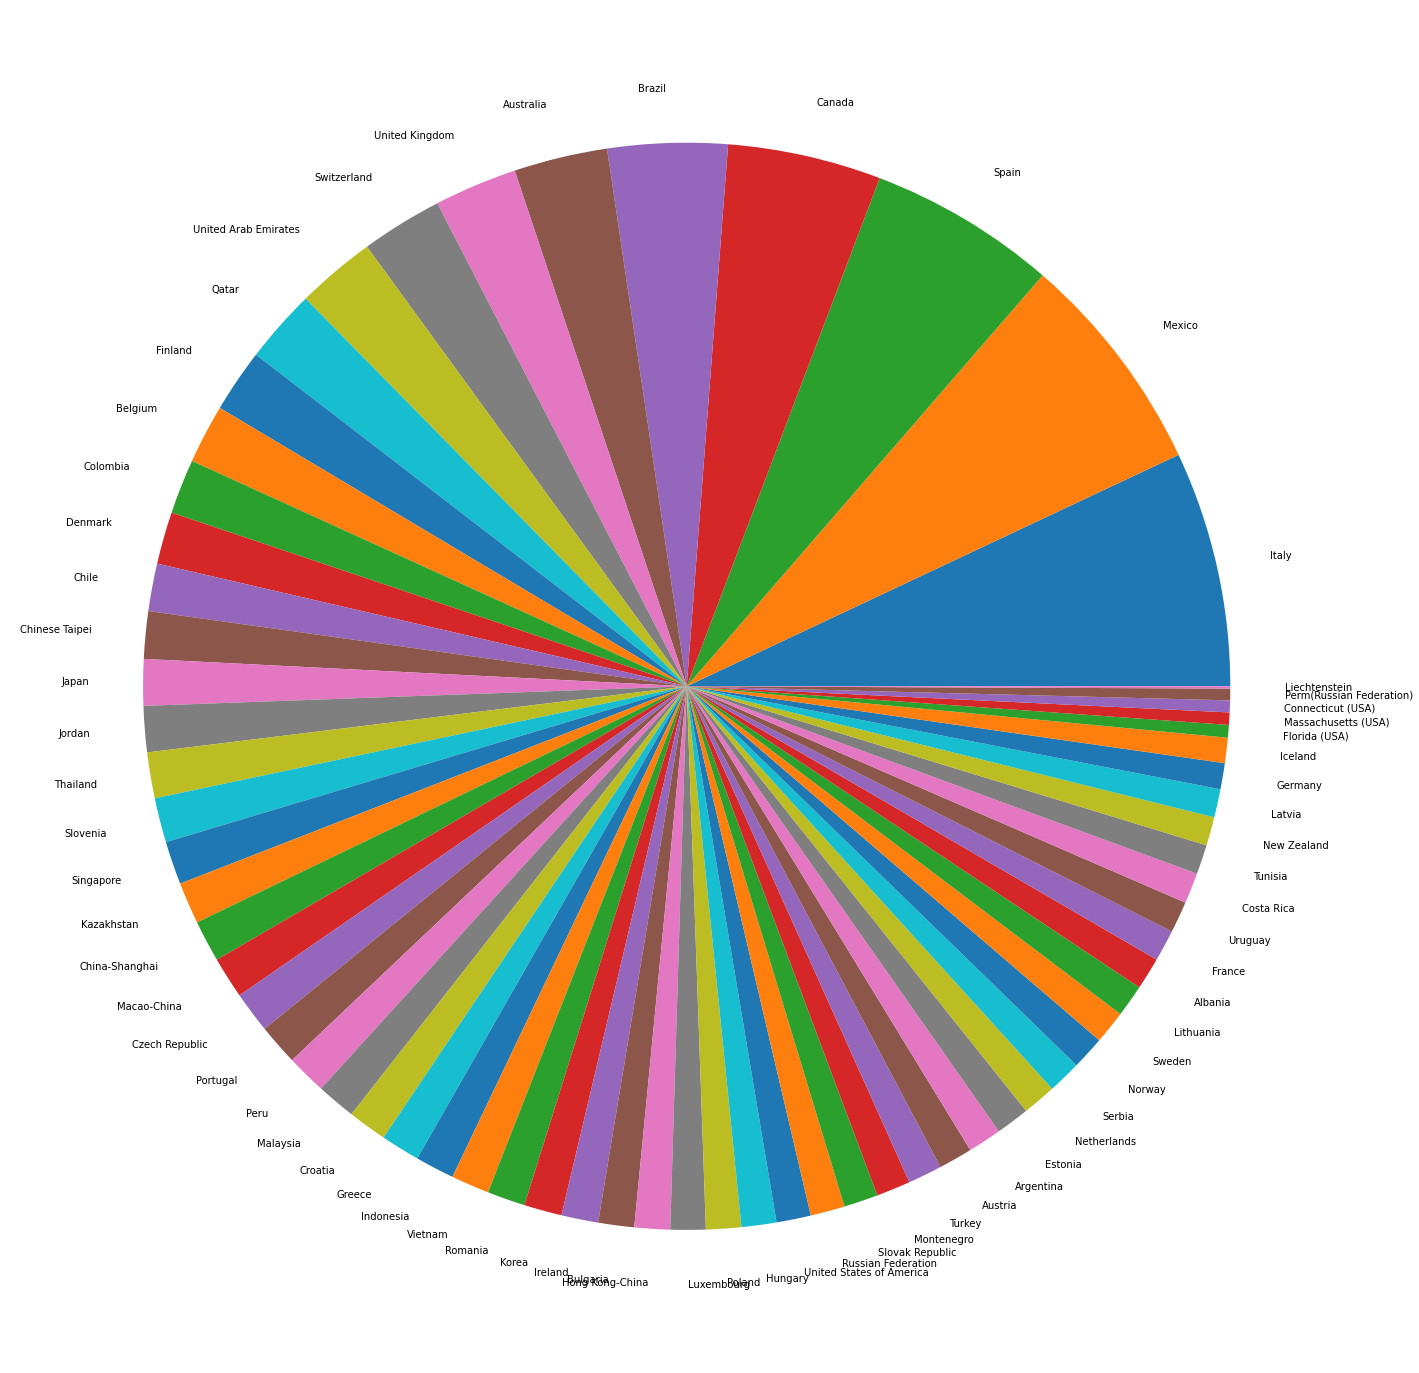

In [29]:
# Plot distribution of students grouped by country
plt.figure(figsize= [25,25])
country_counts = df.country.value_counts()
plt.pie(country_counts, labels = country_counts.index);

__Observation__: A total of 68 countries have taken part on PISA study. Most students came from Mexico, Italy, Spain, Canada and Brazil, which make about 25% of the total.

Also interesting for me is, how many students came from OECD and non OECD countries.

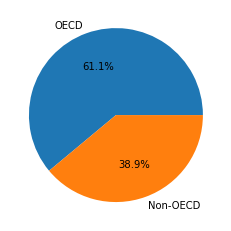

In [30]:
# Plot distribution of OECD and non OECD countries
OECD_counts = df.is_oecd_country.value_counts()
plt.pie(x = OECD_counts, labels = OECD_counts.index, autopct='%1.1f%%');

Text(0.5, 0.98, 'Score distribution by OECD and non OECD couontries')

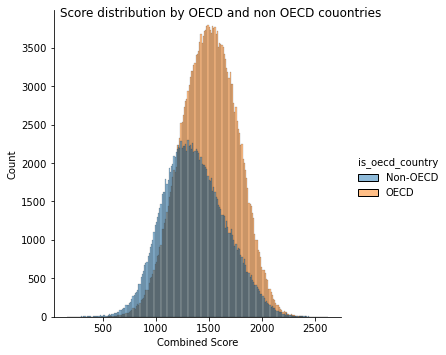

In [274]:
#Plot the score distributions of oecd and on oecd countries
fig =  sb.displot(data=df, x="combined_score", hue="is_oecd_country")
plt.xlabel("Combined Score");
plt.suptitle('Score distribution by OECD and non OECD couontries')

__Observation__: 61.3% of the students are from OECD countries, 38.7% are not. It will be interesting, whether this has any influence on the performance of the students. Later on I will have a look at that.

Now lets have a look on how often parents are born abroad.

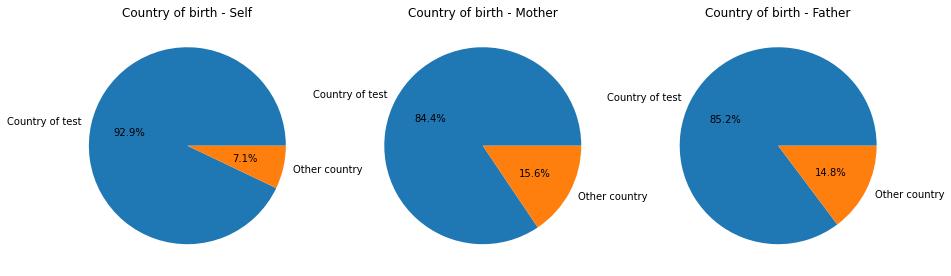

In [31]:
#Plot distribution of born-international for students himself, mother and father
mother_counts = df.mother_birth_country_international.value_counts()
father_counts = df.father_birth_country_international.value_counts()
self_counts = df.self_birth_country_international.value_counts()

fig = plt.figure(figsize= [15,5])
ax1 = plt.subplot(1,3,1)
ax1.title.set_text('Country of birth - Self') 
plt.pie(self_counts, labels = self_counts.index, autopct='%1.1f%%');

ax2 =plt.subplot(1,3,2)
ax2.title.set_text('Country of birth - Mother') 
plt.pie(mother_counts, labels = mother_counts.index, autopct='%1.1f%%');

ax3 =plt.subplot(1,3,3)
ax3.title.set_text('Country of birth - Father') 
plt.pie(father_counts, labels = father_counts.index, autopct='%1.1f%%');

__Observation__: Students themselves are born only to 7% born in another country. For their parents this is the casein 17% of all cases. This could also be a big influence the performance, especially when it comes to reading, given, that in some households the spoken language differs from the language spoken at school. I will take a closer loker at this later on.

Also interesting is the question, how many boys and girls took part.

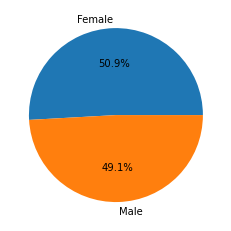

In [32]:
#Plot gender distribution
gender_counts = df.gender.value_counts()
plt.pie(gender_counts, labels = gender_counts.index, autopct='%1.1f%%');

__Observation__: As we can see in the pie chart, there was an approximatly equal number of female and male students. Interesting is, how the different genders performed in math, science and reading. This will be also covered later.

Next I will have a look on how often parents are at home

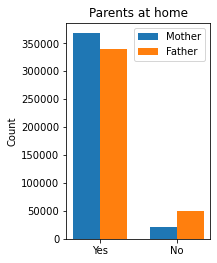

In [33]:
#Plot, how often mothers/fathers are at home and not at home
mother_home_counts = df.at_home_mother.value_counts()
father_home_counts = df.at_home_father.value_counts()

labels = mother_home_counts.index

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig = plt.figure(figsize = [2,3])
ax = fig.add_axes([0,0,1,1])
ax.bar(x - width/2, mother_home_counts, width, label='Mother')
ax.bar(x + width/2, father_home_counts, width, label='Father')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Parents at home')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

__Observation__: As we can see, most of the parents are at home, with a slight advantage of woman. I guess, this is owed to the traditional image of the family.

Now I will have a look a the working situation. This can be also a big factor to predict a students performance.

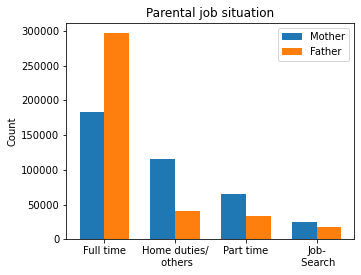

In [325]:
# Get the counts of job stati for mother and fathers
mother_job_counts = df.mother_job_status.value_counts()
father_job_counts = df.father_job_status .value_counts()

labels = mother_job_counts.index

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig = plt.figure(figsize = [4,3])
ax = fig.add_axes([0,0,1,1])
ax.bar(x - width/2, mother_job_counts, width, label='Mother')
ax.bar(x + width/2, father_job_counts, width, label='Father')

# Add some text for labels, title and custom x-axis tick labels
ax.set_ylabel('Count')
ax.set_title('Parental job situation')
ax.set_xticks(x)
ax.set_xticklabels(['Full time','Home duties/\n others','Part time','Job-\n Search'])
ax.legend();

__Observation__: As expected, fathers do work more often fulltime than mothers. On the other side mothers are more often active in home duties or work in part time/look for a job.

Finally I take a look at the distribution of parental education.

In [35]:
#
mother_job_counts = df.mother_highest_overall_edu.value_counts()
mother_job_counts.sort_index(axis=0)

0      13821
1      28927
2      54852
3A     64129
3BC    30153
4      42154
5A     76592
5B     57929
6      20524
Name: mother_highest_overall_edu, dtype: int64

In [36]:
father_job_counts = df.father_highest_overall_edu.value_counts().sort_index(axis=0)

father_job_counts.index

Index(['0', '1', '2', '3A', '3BC', '4', '5A', '5B', '6'], dtype='object')

Text(0.5, 0, 'Parental education level')

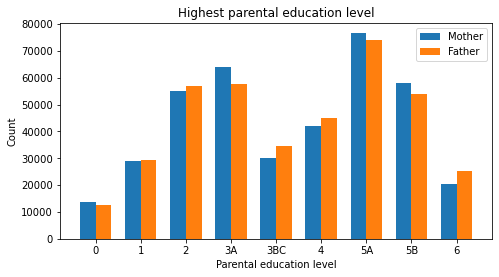

In [37]:
# Get the counts of job stati for mother and fathers
mother_job_counts = df.mother_highest_overall_edu.value_counts().sort_index(axis=0)
father_job_counts = df.father_highest_overall_edu.value_counts().sort_index(axis=0)

labels = mother_job_counts.index

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig = plt.figure(figsize = [6,3])
ax = fig.add_axes([0,0,1,1])
ax.bar(x - width/2, mother_job_counts, width, label='Mother', order)
ax.bar(x + width/2, father_job_counts, width, label='Father')

# Add some text for labels, title and custom x-axis tick labels
ax.set_ylabel('Count')
ax.set_title('Highest parental education level')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend();
ax.set_xlabel('Parental education level')

__Observation__: The graphinc shows the International Standard Classification of Education (ISCED) whcih are ordered in ascending order from left to right. Most parents have 5A as highest level, which correspons to an Bachelor or Master degree on a university. From my intuition, the parental education level should make a impact on the performance of their children. I will invstigate this later on.

__Question:__ How are the out of school lessons, given by parents, distributed?

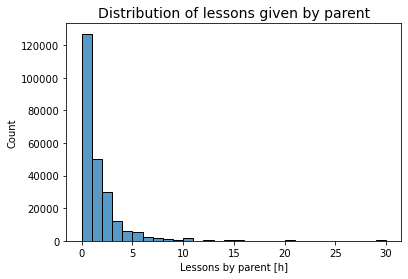

In [329]:
bins = np.arange(0,31,1)
ax = sb.histplot(data = df.lessons_with_Parent, bins = bins);
ax.set_xlabel('Lessons by parent [h]')
ax.set_ylabel('Count')
ax.set_title('Distribution of lessons given by parent', fontsize = 14);

__Observation:__ The distribution is strongly right skewed, with a maximum of 125220 at 0 hours, and nearly no cases with more than 15 hours.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?
My variables of interest are the scores in math, reading and science as well as the combined score. I didn't have to use any transformation, because there were no missing values and no outlier, that were unrealistic. Furthermore I found out, that all scores are normal distributed. 


### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?
There were no unusual distributions between the features, that I investigated. However, some changes were made in order to make the data more usable. Those were:
* The columns, that describe the education of a parent, can be condensed to one single column, since I am only interested in the highest education level, be it school or non school. That column contains the single highest education stage and is of type ordered category. Finally all columns related to the parental education level were droped besides the the newly created.
* Rows, that contained a NAN Value in any column besides those, that describe out of school lessons, were dropped. I did this, because I wanted a dense dataset.
* Following columns were casted from type object to categorical
    * OECD
    * Country
    * Gender
    * Mother/father at home
    * Mother/father job status
    * Self, mother, father birth country

## Bivariate Exploration

At first I want to know, if there is some correlation between the 

Questions:
* Do OECD countries perform better? How is the gender specific difference in OECD and non OECD countries?
* Do the scores correlate
* If self, mother, father is born abroad, does this affect the performance? And are math, reading, science affected differently?
* If mother/father is not at home, how does this affect the performance?
* How does the parental job situation influence the performance
* How does the education of mother/father influence the performnace? Is the influence on male/female students bigger, when mothers have a higher education level?
* Are students with parental lessons out of school better, when the parents got a higher education?


__Question__: One basic question is, if and how the scores in the different areas do correlate.

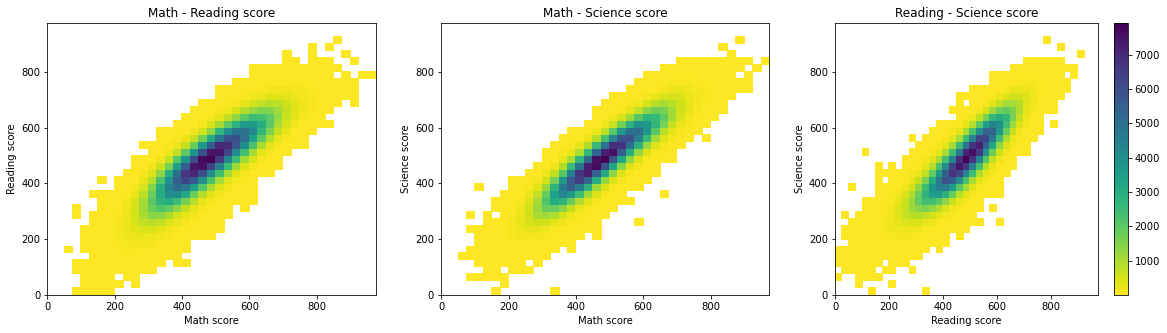

In [40]:
#Create the bins for x- and y-directions
bins_x = np.arange(0, 1000, 25)
bins_y = np.arange(0, 1000, 25)

#Create heatmap plots for scores
fig = plt.figure(figsize = [20,5])
ax1 = plt.subplot(1,3,1)
ax1.set_title('Math - Reading score')
ax1.set_xlabel('Math score')
ax1.set_ylabel('Reading score')
h2d = plt.hist2d(data = df, x = 'math_score', y = 'read_score', cmin=0.5, cmap='viridis_r', bins = [bins_x, bins_y])

ax2 = plt.subplot(1,3,2)
ax2.set_title('Math - Science score')
ax2.set_xlabel('Math score')
ax2.set_ylabel('Science score')
h2d = plt.hist2d(data = df, x = 'math_score', y = 'sci_score', cmin=0.5, cmap='viridis_r', bins = [bins_x, bins_y])

ax3 = plt.subplot(1,3,3)
ax3.set_title('Reading - Science score')
ax3.set_xlabel('Reading score')
ax3.set_ylabel('Science score')
h2d = plt.hist2d(data = df, x = 'read_score', y = 'sci_score', cmin=0.5, cmap='viridis_r', bins = [bins_x, bins_y])
plt.colorbar();

__Observation__: As we can see, there is a very strong correlation between each of the scores. I want to know exactly, how strong the correlation coefficient is of those scores. additionally i will consider the combined score.

__Question__: How well did the coutries perform?

__Question__: How well did the coutries perform

In [214]:
math_ranking_order = df.groupby(by = 'country').mean().math_score.sort_values(axis=0, ascending=False).index
reading_ranking_order = df.groupby(by = 'country').mean().read_score.sort_values(axis=0, ascending=False).index
sci_ranking_order = df.groupby(by = 'country').mean().sci_score.sort_values(axis=0, ascending=False).index
combined_ranking_order = df.groupby(by = 'country').mean().combined_score.sort_values(axis=0, ascending=False).index

In [228]:
# Define base color, that is used for plots
basecolor = sb.color_palette()[0]

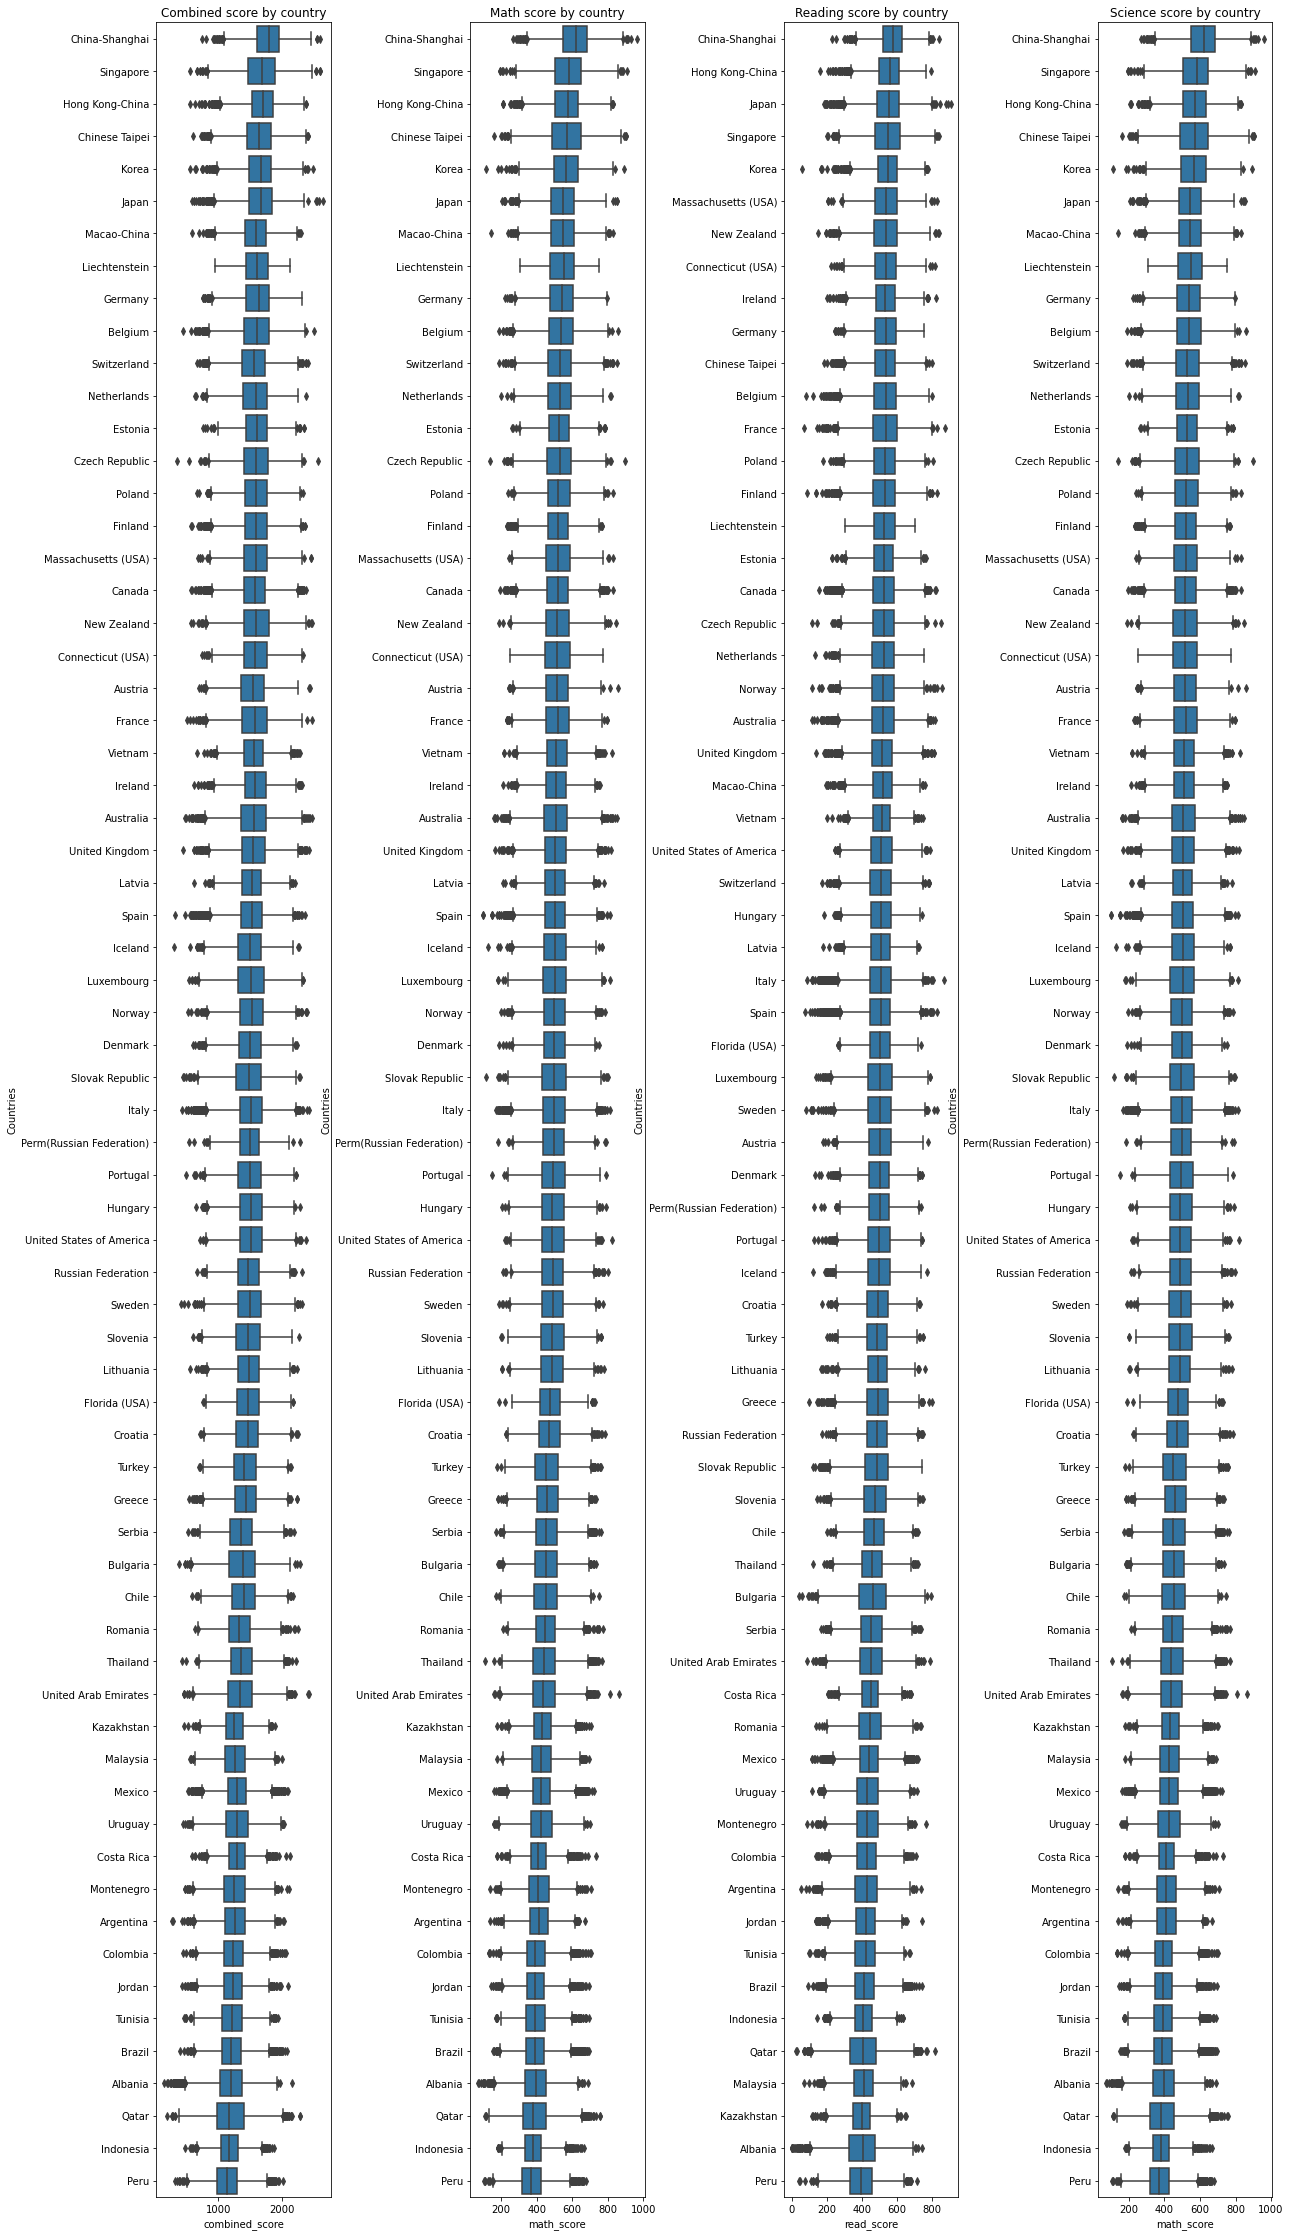

In [230]:
#Plot ranking
plt.figure(figsize = [20, 40])

plt.subplot(1, 4, 1)
sb.boxplot(x = df['combined_score'], y = df['country'], order = math_ranking_order,color = basecolor);
plt.ylabel('Countries')
plt.title('Combined score by country');

plt.subplot(1, 4, 2)
sb.boxplot(x = df['math_score'], y = df['country'], order = math_ranking_order,color = basecolor);
plt.ylabel('Countries')
plt.title('Math score by country');

plt.subplot(1, 4, 3)
sb.boxplot(x = df['read_score'], y = df['country'], order = reading_ranking_order,color = basecolor);
plt.ylabel('Countries')
plt.title('Reading score by country');

plt.subplot(1, 4, 4)
sb.boxplot(x = df['math_score'], y = df['country'], order = math_ranking_order,color = basecolor);
plt.ylabel('Countries')
plt.title('Science score by country');

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.8, hspace=None)

__Question:__ How do male and female perform in the test areas?

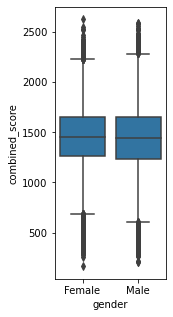

In [110]:
# Plot the boxplot for 
fig = plt.figure(figsize=[2,5])
sb.boxplot(data = df, x = 'gender',y = 'combined_score', color = basecolor);

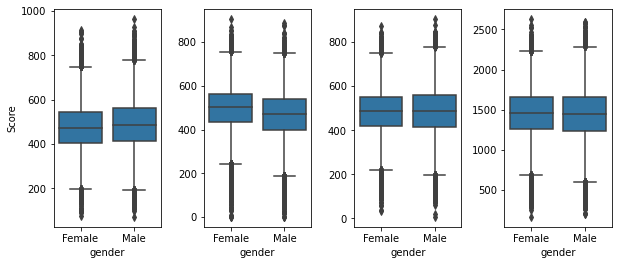

In [280]:
fig = plt.figure(figsize=[10,4])
ax1 = plt.subplot(1,4,1)
sb.boxplot(data = df, x = 'gender',y = 'math_score', color = basecolor);
ax1.set_ylabel('Score')

ax2 = plt.subplot(1,4,2)
sb.boxplot(data = df, x = 'gender',y = 'read_score', color = basecolor);
ax2.set_ylabel('')

ax3 = plt.subplot(1,4,3)
sb.boxplot(data = df, x = 'gender',y = 'sci_score', color = basecolor);
ax3.set_ylabel('')

ax4 = plt.subplot(1,4,4)
sb.boxplot(data = df, x = 'gender',y = 'combined_score', color = basecolor);
ax4.set_ylabel('')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)

In [46]:
df.groupby(by = 'gender').mean()

,math_score,read_score,sci_score,lessons_with_Parent,combined_score
gender,,,,,
Female,474.314975,499.185189,485.097917,1.223004,1458.598081
Male,488.081282,466.533767,488.582008,1.144725,1443.197057


__Observation__: According to the data, female students do better in the reading test, whereas male students perform slightly better in math and science.

__Question:__Now lets see, how the score depends on whether the country is an OECD or non OECD country.

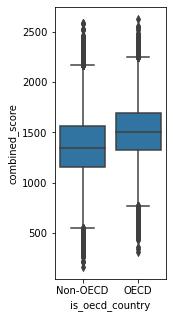

In [47]:
fig = plt.figure(figsize=[2,5])
sb.boxplot(data = df, x = 'is_oecd_country',y = 'combined_score', color = basecolor);

In [48]:
df.groupby(by = df.is_oecd_country).mean().combined_score

is_oecd_country
Non-OECD    1366.377555
OECD        1505.040563
Name: combined_score, dtype: float64

__Observation__: The diagram shows clearly, that the performance OECD countries performed better in the PISA test. And also the spread seems to be lower.

__Question:__ The next question, I want to answer is, how the country of birth of the student/mother/father influences the scores in the different areas.

<Figure size 1440x1440 with 0 Axes>

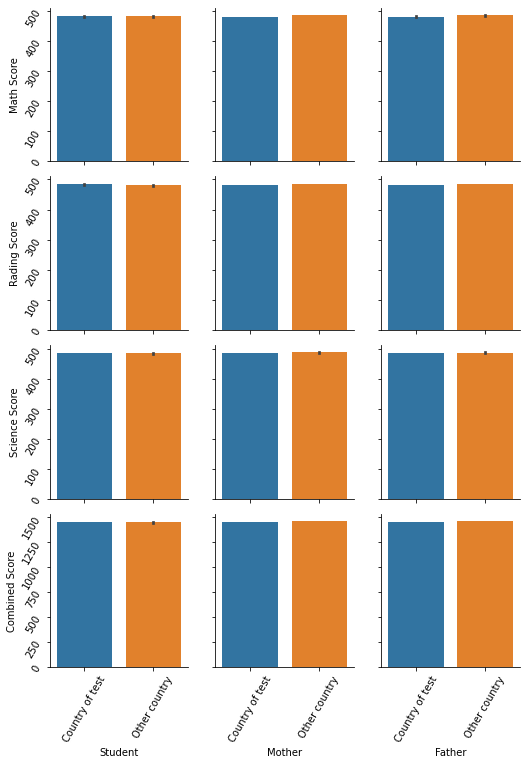

In [49]:
# Plot scores vs country of birth
fig = plt.figure(figsize = [20,20])
fig.suptitle('Influence of birth country on student performance', fontsize=16)

g = sb.PairGrid(data = df, 
                x_vars = ['self_birth_country_international',
                            'mother_birth_country_international', 
                            'father_birth_country_international'],
                y_vars = ['math_score', 'read_score', 'sci_score', 'combined_score'])

g.map(sb.barplot)
g.axes[0,0].set_ylabel('Math Score')


g.axes[1,0].set_ylabel('Rading Score')


g.axes[2,0].set_ylabel('Science Score')


g.axes[3,0].set_ylabel('Combined Score');

g.axes[3,0].set_xlabel('Student');
g.axes[3,1].set_xlabel('Mother');
g.axes[3,2].set_xlabel('Father');

for ax in g.axes.flatten():
    ax.tick_params(rotation = 60)

At this scale we cant see any differences. We have to zoom in to see any difference.

In [50]:
df.self_birth_country_international.value_counts()

Country of test    361513
Other country       27568
Name: self_birth_country_international, dtype: int64

<Figure size 1440x1440 with 0 Axes>

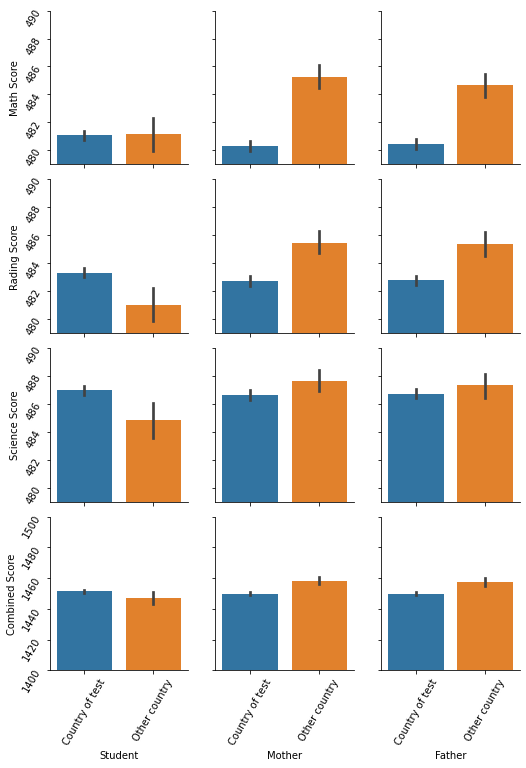

In [51]:
# Plot scores vs country of birth
fig = plt.figure(figsize = [20,20])
fig.suptitle('Influence of birth country on student performance', fontsize=16)

g = sb.PairGrid(data = df, 
                x_vars = ['self_birth_country_international',
                            'mother_birth_country_international', 
                            'father_birth_country_international'],
                y_vars = ['math_score', 'read_score', 'sci_score', 'combined_score'])

g.map(sb.barplot)
g.axes[0,0].set_ylabel('Math Score')
g.axes[0,0].set_ylim(479,490)

g.axes[1,0].set_ylim(479,490)
g.axes[1,0].set_ylabel('Rading Score')

g.axes[2,0].set_ylim(479,490)
g.axes[2,0].set_ylabel('Science Score')

g.axes[3,0].set_ylim(1400,1500)
g.axes[3,0].set_ylabel('Combined Score');

g.axes[3,0].set_xlabel('Student');
g.axes[3,1].set_xlabel('Mother');
g.axes[3,2].set_xlabel('Father');

for ax in g.axes.flatten():
    ax.tick_params(rotation = 60)

In [52]:
df_birth_country = df.groupby(by = ['self_birth_country_international', 'mother_birth_country_international', 'father_birth_country_international']).mean()

__Question__: How is the score affected when student/mother/father are not born in the country of test?

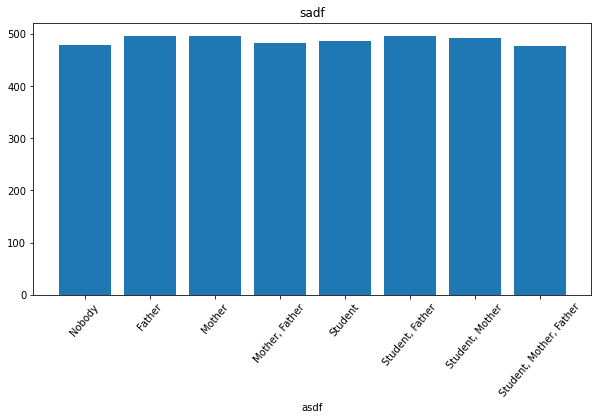

In [233]:
fig = plt.figure(figsize = [10,5])
plt.title('sadf')
plt.xlabel('asdf')
plt.bar(x = ['Nobody', 'Father', 'Mother', 'Mother, Father', 'Student',
             'Student, Father', 'Student, Mother', 'Student, Mother, Father'],height = df_birth_country.math_score, color = basecolor)
plt.xticks(rotation=50);

Text(0.5, 0, 'Not born in country of test')

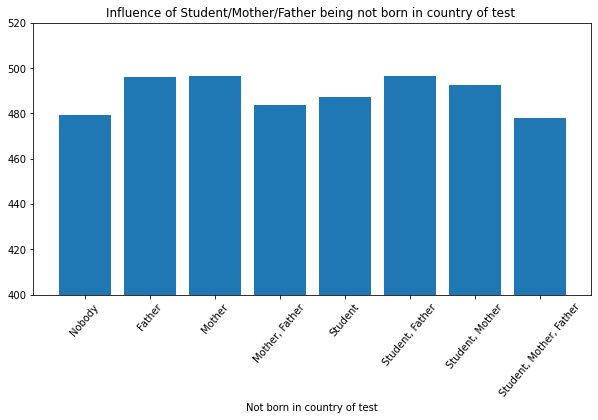

In [55]:
fig = plt.figure(figsize = [10,5])

plt.bar(x = ['Nobody', 'Father', 'Mother', 'Mother, Father', 'Student',
             'Student, Father', 'Student, Mother', 'Student, Mother, Father'],height = df_birth_country.math_score)
plt.xticks(rotation=50)
plt.ylim(400, 520)
plt.title('Influence of Student/Mother/Father being not born in country of test ')
plt.xlabel('Not born in country of test')

Text(0.5, 0, 'Not born in country of test')

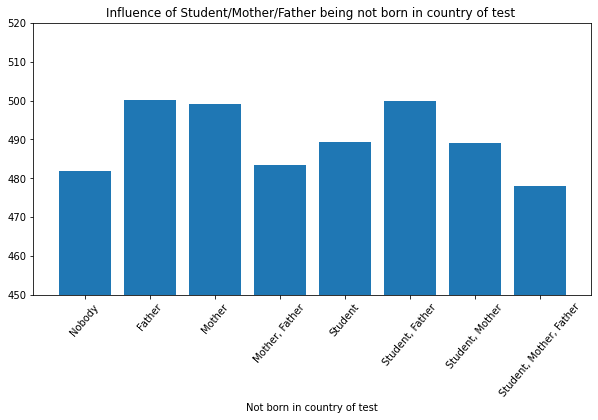

In [56]:
fig = plt.figure(figsize = [10,5])

plt.bar(x = ['Nobody', 'Father', 'Mother', 'Mother, Father', 'Student',
             'Student, Father', 'Student, Mother', 'Student, Mother, Father'],height = df_birth_country.read_score)
plt.xticks(rotation=50)
plt.ylim(450, 520)
plt.title('Influence of Student/Mother/Father being not born in country of test ')
plt.xlabel('Not born in country of test')

Text(0.5, 0, 'Not born in country of test')

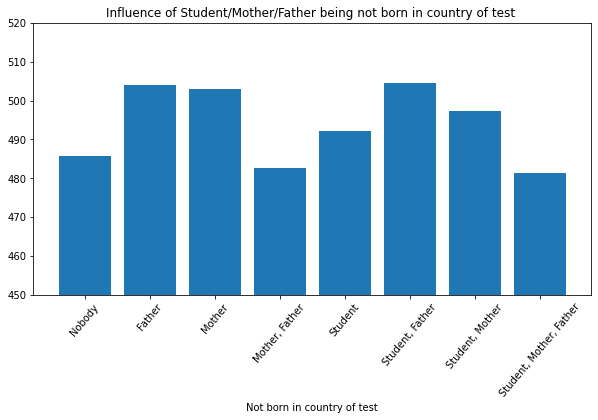

In [57]:
fig = plt.figure(figsize = [10,5])

plt.bar(x = ['Nobody', 'Father', 'Mother', 'Mother, Father', 'Student',
             'Student, Father', 'Student, Mother', 'Student, Mother, Father'],height = df_birth_country.sci_score)
plt.xticks(rotation=50)
plt.ylim(450, 520)
plt.title('Influence of Student/Mother/Father being not born in country of test ')
plt.xlabel('Not born in country of test')

Text(0.5, 0, 'Not born in country of test')

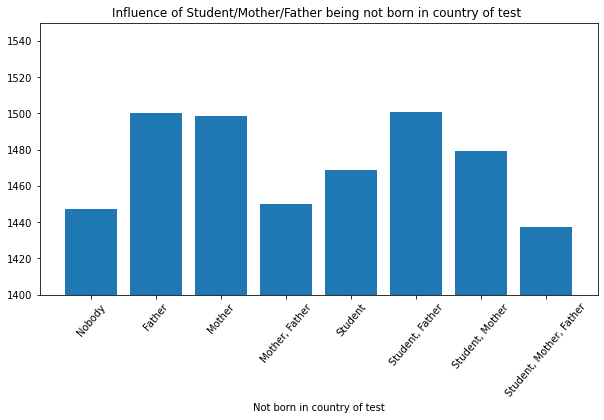

In [58]:
fig = plt.figure(figsize = [10,5])

plt.bar(x = ['Nobody', 'Father', 'Mother', 'Mother, Father', 'Student',
             'Student, Father', 'Student, Mother', 'Student, Mother, Father'],height = df_birth_country.combined_score)
plt.xticks(rotation=50)
plt.ylim(1400, 1550)
plt.title('Influence of Student/Mother/Father being not born in country of test ')
plt.xlabel('Not born in country of test')

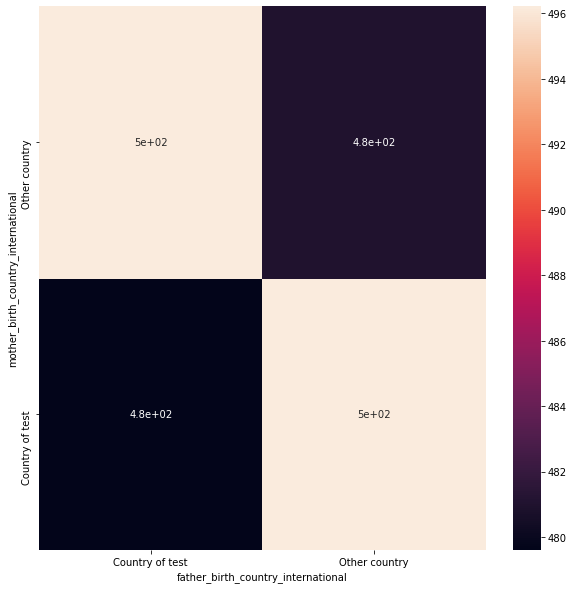

In [64]:

table = pd.pivot_table(df, values='math_score', index='mother_birth_country_international', columns='father_birth_country_international', aggfunc=np.mean)
fig = plt.figure(figsize=[10,10])
ax = sb.heatmap(table, annot = True)
ax.invert_yaxis()

Text(0, 0.5, '')

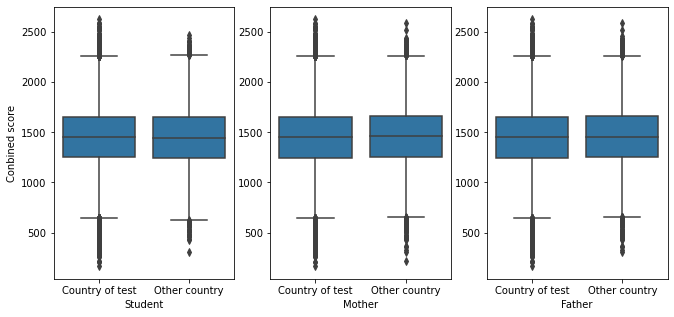

In [65]:
#Plot scores vs. country of birth
fig = plt.figure(figsize = [11,5])
ax1 = plt.subplot(1,3,1)
sb.boxplot(data = df, x = 'self_birth_country_international', y = 'combined_score', color = basecolor);
ax1.set_xlabel('Student')
ax1.set_ylabel('Conbined score')

ax2 = plt.subplot(1,3,2)
sb.boxplot(data = df, x = 'mother_birth_country_international', y = 'combined_score', color = basecolor);
ax2.set_xlabel('Mother')
ax2.set_ylabel('')

ax3 = plt.subplot(1,3,3)
sb.boxplot(data = df, x = 'father_birth_country_international', y = 'combined_score', color = basecolor);
ax3.set_xlabel('Father')
ax3.set_ylabel('')

__Observation__: If the student self, mother or father is born in another country than the test country, there is almost no difference in the combined score. However I want to check, whtether this is also valid for all single scores.

__Question__: Is there any dependency of the performance on a parent beeing at home?

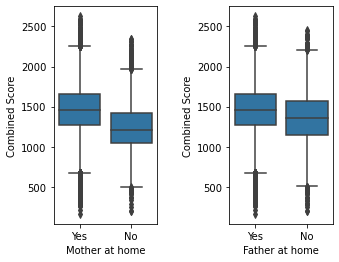

In [237]:
fig = plt.figure(figsize = [5,4])
ax1 = plt.subplot(1,2,1)
sb.boxplot(data = df, x = 'at_home_mother',y = 'combined_score', color = basecolor);
ax1.set_ylabel('Combined Score')
ax1.set_xlabel('Mother at home')

ax2 = plt.subplot(1,2,2)
sb.boxplot(data = df, x = 'at_home_father',y = 'combined_score', color = basecolor);
ax2.set_ylabel('Combined Score')
ax2.set_xlabel('Father at home');


plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.7, hspace=None)

__Observation__: Students perform at best, when both parents are at home and worst, when no parent is at home. A further investigation could be, how the performance changes, when both, no or a single parent is at home.

Now lets see, how the job status of parents influences the performance of their children

In [67]:
# Get labels of the bars
labels = df.mother_job_status.value_counts().index
labels

Index(['Working full-time <for pay>', 'Other (e.g. home duties, retired)',
       'Working part-time <for pay>', 'Not working, but looking for a job'],
      dtype='object')

In [68]:
# Create order of the bars
order_list = [labels[0], labels[2], labels[1], labels[3]]

Text(0.5, 0.98, 'Influence of parental job status on score')

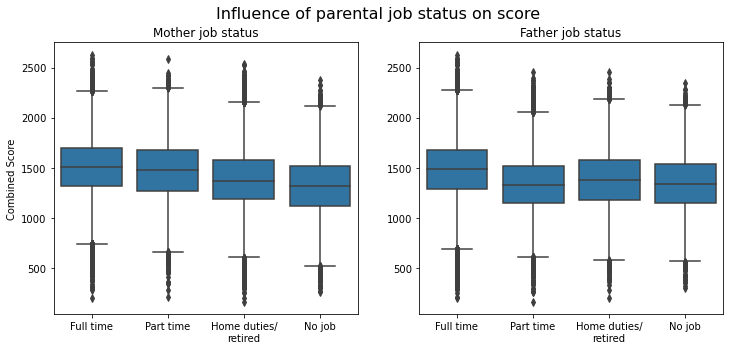

In [69]:
fig = plt.figure(figsize = [12,5])
ax0 = plt.subplot(1,2,1)
sb.boxplot(data = df, x = 'mother_job_status',y = 'combined_score', color = basecolor, order = order_list);
ax0.set_xticklabels(['Full time','Part time','Home duties/\nretired','No job'])
ax0.set_ylabel('Combined Score')
ax0.set_title('Mother job status')
ax0.set_xlabel('')

ax1 = plt.subplot(1,2,2)
sb.boxplot(data = df, x = 'father_job_status',y = 'combined_score', color = basecolor, order = order_list);
ax1.set_xticklabels(['Full time','Part time','Home duties/\nretired','No job'])
ax1.set_ylabel('')
ax1.set_title('Father job status')
ax1.set_xlabel('')

fig.suptitle('Influence of parental job status on score', fontsize=16)

__Observation__: The performance of students seems to be better, the more fathers work. The worst performance is, when fathers have no job.
For case of mothers, the students performance is best for the job status woring full time, then other, then working part time and 
job status fathers it seems, that
When mothers work full or part time, scores are the highest. For father, scores are only highest when they work full time.  

__Question__: Next I wanna evaluate, whether the performance of a students is affected by the educational level of their parents.

In [70]:
edu_order = ['1','2','3BC', '3A',  '4','5B', '5A', '6']

Text(0.5, 0, 'Highest education')

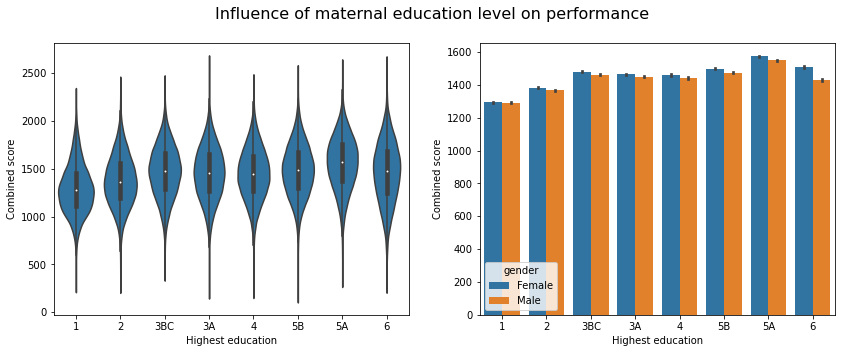

In [71]:
#Plot dependency of performance of mothers educational level
fig = plt.figure(figsize = [14,5])
fig.suptitle('Influence of maternal education level on performance', fontsize=16)
ax0 = plt.subplot(1,2,1)
sb.violinplot(data = df, x = 'mother_highest_overall_edu',y = 'combined_score', color = basecolor, order = edu_order);
ax0.set_ylabel('Combined score')
ax0.set_xlabel('Highest education')

ax1 = plt.subplot(1,2,2)
sb.barplot(data = df, x = 'mother_highest_overall_edu',y = 'combined_score', hue = 'gender', order = edu_order);
ax1.set_ylabel('Combined score')
ax1.set_xlabel('Highest education')

Text(0.5, 0, 'Highest education')

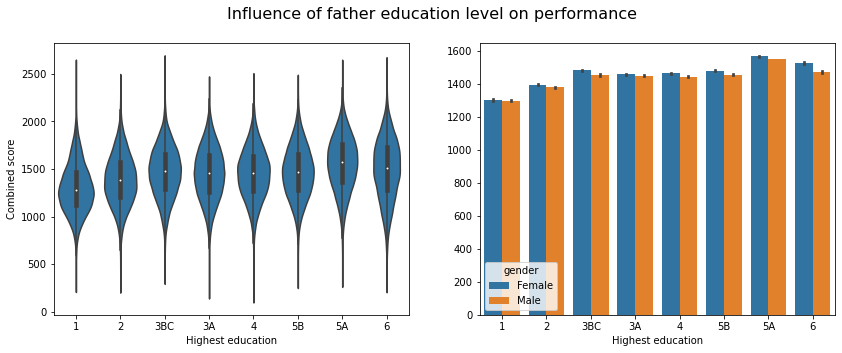

In [313]:
#Plot dependency of performance of father educational level
fig = plt.figure(figsize = [14,5])
fig.suptitle('Influence of father education level on performance', fontsize=16)

ax0 = plt.subplot(1,2,1)
sb.violinplot(data = df, x = 'father_highest_overall_edu',y = 'combined_score', color = basecolor, order = edu_order);
ax0.set_ylabel('Combined score')
ax0.set_xlabel('Highest education')


ax1 = plt.subplot(1,2,2)
sb.barplot(data = df, x = 'father_highest_overall_edu',y = 'combined_score', hue = 'gender', order = edu_order)
ax1.set_ylabel('')
ax1.set_xlabel('Highest education')

__Observation__: The two diagrams shows cleary, that the perfomance increases with a higher school education of the parents. However it seems, that the parental non school education doesn't affect the performance, the performance of students stagnates on a high level. Only education levels 5A and 6 seem to improve performances a bit. 
Also interesting to evaluate would be, how the different combinations of education influence the performance of the student. I will look at this later.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?
The scores in math, science and reading, which are my variables of interest, seem to have a strong correlation between each other. Later on, i will look at the correlation coefficients.

The scores of students also strongly depend on the country, the test was taken. The highest average scores in each test area were achieved in China-Shanghai. Very obvious is also, that a couple of countries always are on top, namely China-Shanghai, Hong Kong-China, Singapore. Obviously however those are not realy countries, but cities. Given, that eventually education is better in non rural districts, those results are not very survprising. If we only look at countries, that are not city like, Korea, Japan, Germany, Estonia and Liechtenstein make the race.

The countries, that took part, can also be devided in OECD and non OECD countries. Cleary OECD countries outscored non OECD countries.

The sex of a student seems to have an influence on the score also. Overall female students achieve better results, but looking at the specific areas, they only perform better in reading by a wide marching, while male students perform better in math and science.

Another parameter I was looking at was, whether the score is affected when student/mother/father were born in the country of test or not. Students, that were born in the country of test, perform better in reading and science than born abroad students. In math however they perform equally well. If the mother was born abroad, the students perform better in each subject, however with the biggest margin in math. The same is true in case of the father. A further investigation however revealed, that if both parents are born abroad, this effect vanishes. Only if one parental part is born abroad, the student outperforms. 

The score is also influence by a parent beeing at home. Students perform better, when mother/father are at home and worst, when no parent is at home. A further investigation could be, how the performance changes, when both, no or a single parent is at home.

Next I investigated, how the job status of the parents influences the students performance. The performance of students seems to be better, the more fathers work. The worst performance is, when fathers have no job. In case of mothers, the students performance is best for the job status woring full time, then other, then working part time and job status fathers it seems, that When mothers work full or part time, scores are the highest. For father, scores are only highest when they work full time.

And last but not lest, I looked the role of the parental education. The perfomance increases with a higher school education of each parent. However it seems, that the parental non school education doesn't affect the performance, the performance of students stagnates on a high level. Only education levels 5A and 6 seem to improve performances a bit. Also interesting to evaluate would be, how the different combinations of education influence the performance of the student. I will look at this later.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

No, there were no investigations made.

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

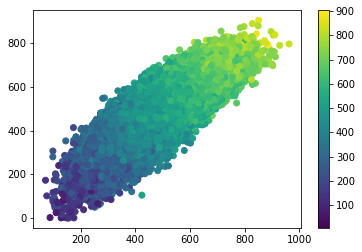

In [73]:
plt.scatter(data = df, x = 'math_score', y = 'read_score', c ='sci_score')
plt.colorbar();

__Question:__ How do the different scores correlate to each other?

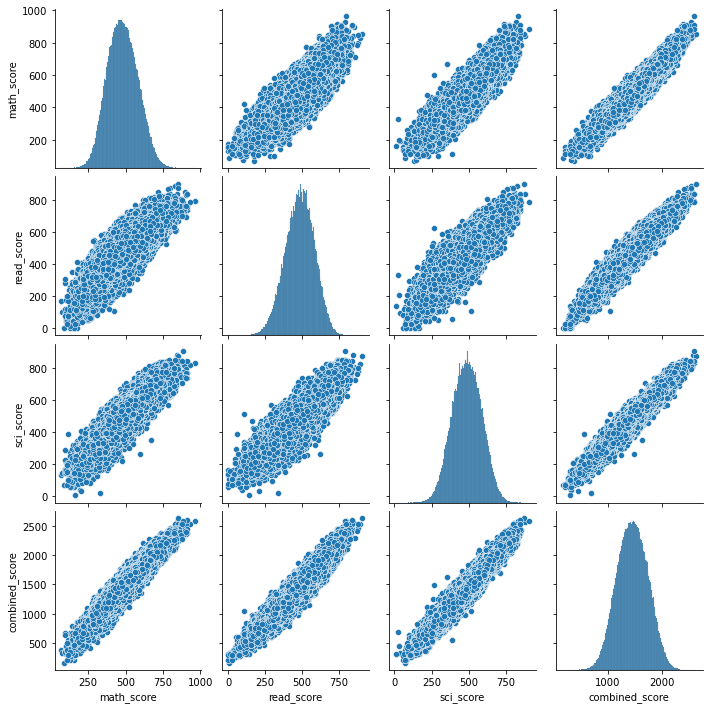

In [283]:
g = sb.pairplot(data = df, vars = ['math_score', 'read_score', 'sci_score','combined_score'])
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)

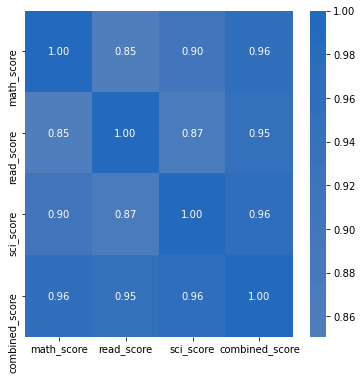

In [286]:
fig = plt.figure(figsize=[6,6])

sb.heatmap(df[['math_score', 'read_score', 'sci_score','combined_score']].corr(), annot = True, fmt = '.2f', cmap = 'vlag_r', center = 0);


__Observation__: The correlation is measured with the Perason correliaiton coefficient. The coefficient between the combined score and each of the single scores seems to be higher than between two single scores. This means, if we want to evaluate the raw performance, the combined score is more meaningful. As we can see, the correaltion coefficient between the combined score and any other single score is at least 0.95. Opposed to this, the highest correlation coefficient between two single scores is 0.90 (Math-Science). This means, that the combined score is a very good parameter to measure the overall performance.
Also interesting is, that the correlation coefficient between maths and science is higher (0.9) than the correlation between reading and math (0.85) or reading and science (0.87).

__Question:__ How does the job status of parents affect the score?

__Question__: How does the education level of both parents influence students performance?

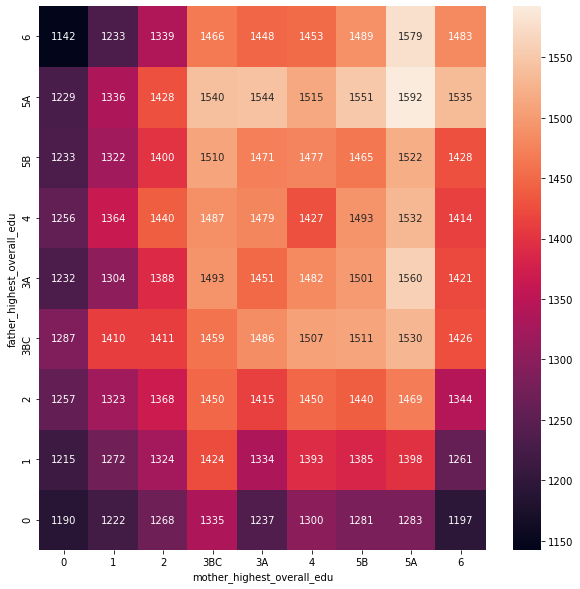

In [293]:
table = pd.pivot_table(df, values='combined_score', index='father_highest_overall_edu', columns='mother_highest_overall_edu', aggfunc=np.mean)
table.sort_index(level=0, ascending=True, inplace=True)
table.sort_index(level=1, ascending=True, inplace=True)
fig = plt.figure(figsize=[10,10])
ax = sb.heatmap(table, annot = True, fmt = '.0f')
ax.invert_yaxis()

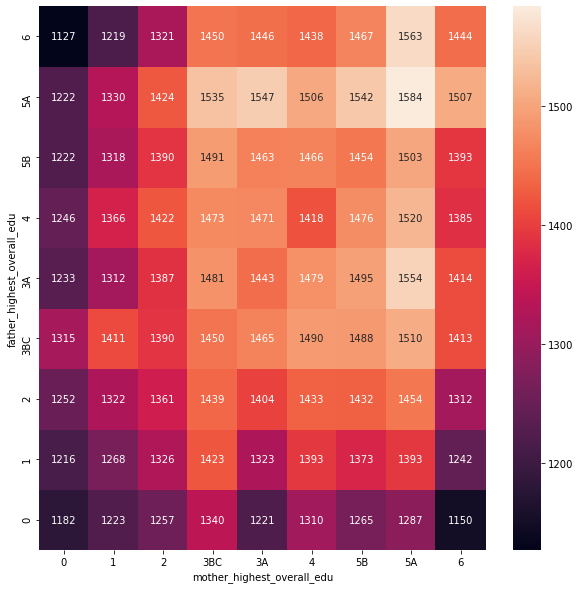

In [292]:
df_male = df[df['gender'] == 'Male']
table = pd.pivot_table(df_male, values='combined_score', index='father_highest_overall_edu', columns='mother_highest_overall_edu', aggfunc=np.mean)
table.sort_index(level=0, ascending=True, inplace=True)
table.sort_index(level=1, ascending=True, inplace=True)
fig = plt.figure(figsize=[10,10])
ax = sb.heatmap(table, annot = True, fmt = '.0f')
ax.invert_yaxis()

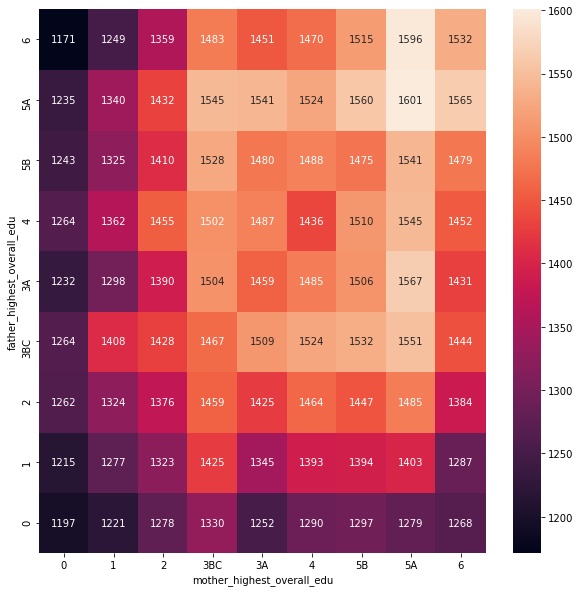

In [291]:
df_female = df[df['gender'] == 'Female']
table = pd.pivot_table(df_female, values='combined_score', index='father_highest_overall_edu', columns='mother_highest_overall_edu', aggfunc=np.mean)
table.sort_index(level=0, ascending=True, inplace=True)
table.sort_index(level=1, ascending=True, inplace=True)
fig = plt.figure(figsize=[10,10])
ax = sb.heatmap(table, annot = True, fmt = '.0f',)
ax.invert_yaxis()

__Observation__: For both, male and female students, the combined score generally increases, when the education level of both parents is high. The best average performance is achieved, when both parents have education level 5A.

__Question__: Does it make a differences for male/female students, when their father/mother has the higher education?

In [142]:
# Create a dataframe, that contains the performance difference of males and female students for same parental education levels
male_students = df_male.groupby(['father_highest_overall_edu','mother_highest_overall_edu']).mean().combined_score
female_students = df_female.groupby(['father_highest_overall_edu','mother_highest_overall_edu']).mean().combined_score
diff.sort_index(level=0, ascending=True, inplace=True)
diff.sort_index(level=1, ascending=True, inplace=True)
diff = female_students - male_students
diff = diff.unstack(level = 1)
diff

mother_highest_overall_edu,0,1,2,3BC,3A,4,5B,5A,6
father_highest_overall_edu,,,,,,,,,
0,14.820971,-1.700069,21.271440,-10.721821,31.103780,-19.927069,32.207808,-7.393671,117.917048
1,-0.522386,9.023446,-2.984646,2.518879,21.758841,-0.637204,20.797759,9.601143,44.475028
2,9.845882,2.106528,14.865014,20.640744,21.510072,30.746946,15.566786,30.231745,72.664637
3BC,-50.834767,-2.663849,38.297787,17.250242,44.169874,34.065719,44.268251,40.894443,31.480601
3A,-1.113718,-13.461441,2.896678,22.701578,15.719755,5.878198,11.187601,12.428066,17.111908
4,17.712531,-4.498076,32.734432,29.149653,16.578174,17.619837,34.150214,25.162323,66.849348
5B,20.972514,6.956426,20.446211,37.022748,16.537710,21.950822,21.456871,38.090560,86.578492
5A,13.067667,9.849132,7.551372,10.065499,-5.682349,17.917433,18.464891,17.222576,57.291287
6,43.987915,29.464164,38.112425,33.043689,5.313865,31.968578,47.345921,32.785129,87.206003


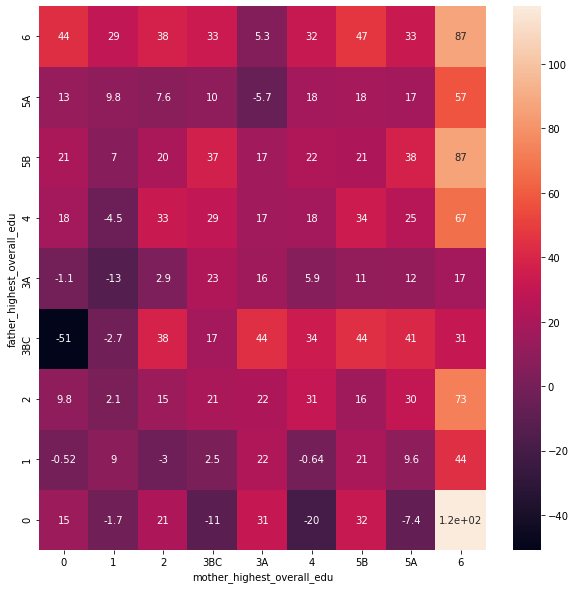

In [143]:
fig = plt.figure(figsize=[10,10])
ax = sb.heatmap(diff, annot = True)
ax.invert_yaxis()

__Observation__: The heatmap shows in the upper right corner higher positive values, meaning, that female students perform even better than male students, when their parents both got a high education level. In the bottom left corner, the opposite seems to be true, meaning, that low education levels of parents cause a better performance of male students. 
Overmore, a high education level of the mother boosts the performance of female students. The highest relative difference between female and male students can be found, when the mother got level 6  and the father level 0. Maybe mothers are a role model for their daughter in those cases.

__Question__: Does the performance difference of male and female students differ in OECD and non OECD countries?

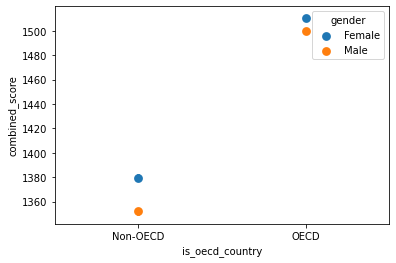

In [147]:
ax = sb.pointplot(data = df, x = 'is_oecd_country', y = 'combined_score', hue = 'gender', linestyles='')

In [81]:
df.groupby(['gender', 'is_oecd_country']).mean()

math_score  read_score   sci_score  \
gender is_oecd_country                                       
Female Non-OECD         448.758974  471.915532  458.980001   
       OECD             491.102716  517.098630  502.254779   
Male   Non-OECD         458.291342  436.940794  456.878605   
       OECD             506.514550  484.845157  508.199279   

                        lessons_with_Parent  combined_score  
gender is_oecd_country                                       
Female Non-OECD                    1.508919     1379.654508  
       OECD                        1.048173     1510.456126  
Male   Non-OECD                    1.478991     1352.110742  
       OECD                        0.951326     1499.558986

__Observation:__ As we already knew, the combined score is on average higher in OECD countries. Additionally I discovered, that in OECD countries the gender gap is smaller than in non OECD countries. In OECD countries, female students have 11 points more than male students, in non OECD countries, this increases to 27 points. 

__Question:__ How does the performance of students change, when no, only one or both parents are at home?

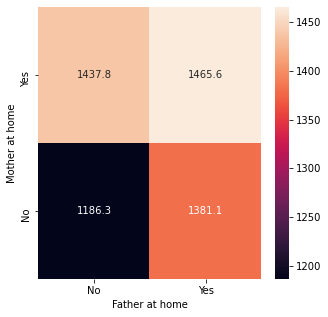

In [299]:
table = pd.pivot_table(df, values='combined_score', index='at_home_mother', columns='at_home_father', aggfunc=np.mean)
fig = plt.figure(figsize = (5,5))
ax = sb.heatmap(table,annot = True, fmt = '.1f')
ax.set_xlabel('Father at home')
ax.set_ylabel('Mother at home')
ax.invert_yaxis()
plt.show()

__Observation__: Students perform at their best, when both parents are at home and worst, when no parent is at home. If one parent is at home, they perform better, when the parent is they mother. 

__Question:__ How does the job situation affect the performance?

In [83]:
table = pd.pivot_table(df, values='combined_score', index='mother_job_status', columns='father_job_status', aggfunc=np.mean)
table

father_job_status,"Not working, but looking for a job","Other (e.g. home duties, retired)",Working full-time <for pay>,Working part-time <for pay>
mother_job_status,,,,
"Not working, but looking for a job",1229.256600,1311.816316,1365.610005,1237.816425
"Other (e.g. home duties, retired)",1297.929635,1326.015413,1420.693131,1291.079953
Working full-time <for pay>,1428.174440,1493.042268,1511.835331,1420.424042
Working part-time <for pay>,1370.990838,1445.408322,1515.204073,1341.021651


In [301]:
table = pd.pivot_table(df, values='combined_score', index='mother_job_status', columns='father_job_status', aggfunc=np.mean)
table = table.rename(mapper = {'Not working, but looking for a job ': 'Not working, but looking for a job'})
new_order = ['Not working, but looking for a job',
             'Other (e.g. home duties, retired)',
             'Working part-time <for pay>',
             'Working full-time <for pay>']
table = table.reindex(new_order)
table = table.reindex(new_order, axis = 1)
table

father_job_status,"Not working, but looking for a job","Other (e.g. home duties, retired)",Working part-time <for pay>,Working full-time <for pay>
mother_job_status,,,,
"Not working, but looking for a job",1229.256600,1311.816316,1237.816425,1365.610005
"Other (e.g. home duties, retired)",1297.929635,1326.015413,1291.079953,1420.693131
Working part-time <for pay>,1370.990838,1445.408322,1341.021651,1515.204073
Working full-time <for pay>,1428.174440,1493.042268,1420.424042,1511.835331


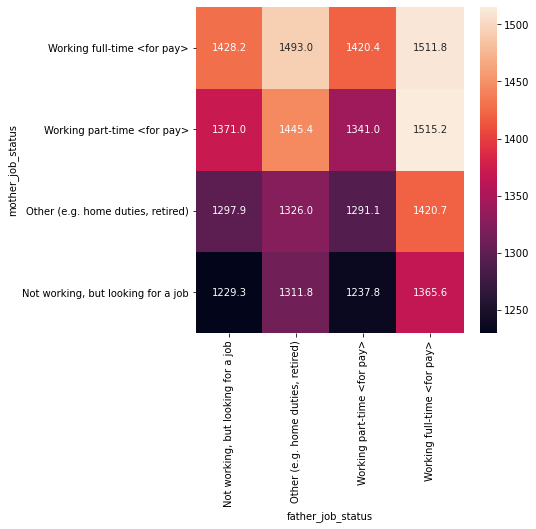

In [302]:
fig = plt.figure(figsize=[6,6])
ax = sb.heatmap(table,annot = True, fmt = '.1f')
ax.invert_yaxis()
plt.show()

__Observation__: Students perform best, when their father works full time and their mother full or part time. They perform worst, when both parents are not working or their mother is nott working and their father only part time. Generally it seems, that the more both parents work, their better higher is the score of their children.

__Question:__ How do parental lessons correlate with performance?

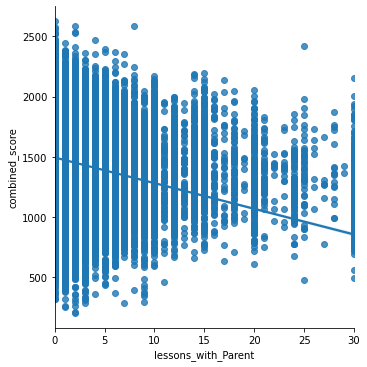

In [324]:
ax = sb.lmplot(x="lessons_with_Parent", y="combined_score", data=df)

In [166]:
df[['lessons_with_Parent','combined_score']].corr()

,lessons_with_Parent,combined_score
lessons_with_Parent,1.000000,-0.175865
combined_score,-0.175865,1.000000


In [197]:
df_lessons_reg = df[df['lessons_with_Parent'].notna()]
X = df_lessons_reg.lessons_with_Parent
Y = df_lessons_reg.combined_score
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

In [198]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         combined_score   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     7632.
Date:                Mon, 22 Nov 2021   Prob (F-statistic):               0.00
Time:                        19:07:11   Log-Likelihood:            -1.6825e+06
No. Observations:              239135   AIC:                         3.365e+06
Df Residuals:                  239133   BIC:                         3.365e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1496.0731    

__Observation__: It seems, that lessons given by a parent correlate negative with the combined score. In a certain way this is what one would expect, because only students, who need to get better receive extra lessons. Students perform on average 21.3 points worse per received lesson. The p-value of 0.0 shows, that the null hypothesis can be rejected. The null hyphothesis is in this case, that the independent variables const and lesson_hours have no influence on the dependent variable diff_score.

Now I wanna know, whether there is some gender specific difference, in how students profit of additional lessons by parents.

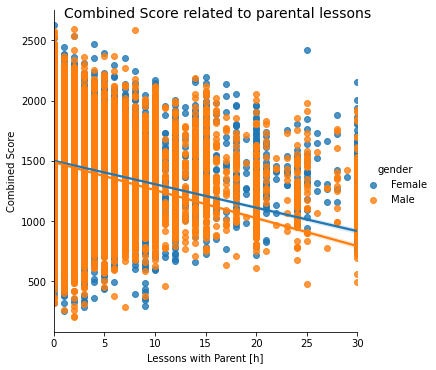

In [328]:
g = sb.lmplot(x="lessons_with_Parent", y="combined_score", hue ='gender', data=df);
g.axes[0,0].set_ylabel('Combined Score')
g.axes[0,0].set_xlabel('Lessons with Parent [h]')
g.fig.suptitle('Combined Score related to parental lessons', fontsize = 14);

In [190]:
df_lessons_reg_male = df_lessons_reg[df_lessons_reg['gender'] == 'Male']
X = df_lessons_reg_male.lessons_with_Parent
Y = df_lessons_reg_male.combined_score
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

In [191]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         combined_score   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     4298.
Date:                Mon, 22 Nov 2021   Prob (F-statistic):               0.00
Time:                        18:52:55   Log-Likelihood:            -8.2929e+05
No. Observations:              117402   AIC:                         1.659e+06
Df Residuals:                  117400   BIC:                         1.659e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1490.2234    

In [192]:
df_lessons_reg_female = df_lessons_reg[df_lessons_reg['gender'] == 'Female']
X = df_lessons_reg_female.lessons_with_Parent
Y = df_lessons_reg_female.combined_score
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

In [193]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         combined_score   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     3381.
Date:                Mon, 22 Nov 2021   Prob (F-statistic):               0.00
Time:                        18:52:55   Log-Likelihood:            -8.5290e+05
No. Observations:              121733   AIC:                         1.706e+06
Df Residuals:                  121731   BIC:                         1.706e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1501.6213    

__Observation:__ For each lesson hour the score difference between female and male students increases. Males perform 23.24 points worse for each received lessons, females only 19.49. Maybe female students get more profit of given lessons given by a parent.

In [ ]:
df_gender_lessons

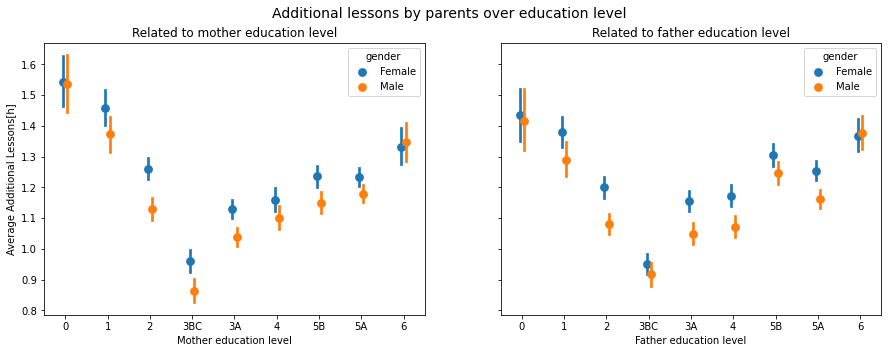

In [327]:
fig, (ax1, ax2) = plt.subplots(figsize = [15,5], nrows=1, ncols=2, sharey=True);
fig.suptitle('Additional lessons by parents over education level', fontsize = 14)

sb.pointplot(data = df, x = 'mother_highest_overall_edu', y = 'lessons_with_Parent', hue = 'gender', linestyles='', dodge=0.1, ax= ax1)
ax1.set_xlabel('Mother education level')
ax1.set_ylabel('Average Additional Lessons[h]')
ax1.set_title('Related to mother education level')

sb.pointplot(data = df, x = 'father_highest_overall_edu', y = 'lessons_with_Parent', hue = 'gender', linestyles='', dodge=0.1, ax=ax2)
ax2.set_xlabel('Father education level')
ax2.set_ylabel('')
ax2.set_title('Related to father education level');

__Observation:__ It seems like girls usually get more lessons from their parents, indepently of the education level

<Figure size 1080x1080 with 0 Axes>

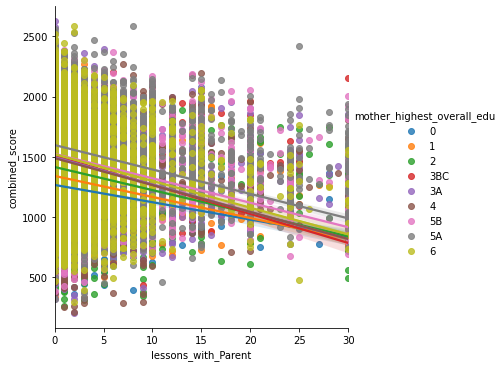

In [326]:
fig = plt.figure(figsize=[15,15])
sb.lmplot(x="lessons_with_Parent", y="combined_score", hue ='mother_highest_overall_edu', data=df)

In [200]:
df_0 = df[df['mother_highest_overall_edu'] == '0']
df_1 = df[df['mother_highest_overall_edu'] == '0']
df_2 = df[df['mother_highest_overall_edu'] == '0']
df_0 = df[df['mother_highest_overall_edu'] == '0']
df_0 = df[df['mother_highest_overall_edu'] == '0']
df_0 = df[df['mother_highest_overall_edu'] == '0']
df_6 = df[df['mother_highest_overall_edu'] == '6']

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

There is a strong correlation between the score in each of the tested subjects as well as the combined score.
The coefficient between the combined score and each of the single scores seems to be higher than between two single scores. This means, if we want to evaluate the raw performance, the combined score is more meaningful. As we can see, the correaltion coefficient between the combined score and any other single score is at least 0.95. Opposed to this, the highest correlation coefficient between two single scores is 0.90 (Math-Science). This means, that the combined score is a very good parameter to measure the overall performance. Also interesting is, that the correlation coefficient between maths and science is higher (0.9) than the correlation between reading and math (0.85) or reading and science (0.87).

Looking at the education level of parents, for male and female students the combined score generally increases, when the education level of both parents is high. The best average performance is achieved, when both parents have education level 5A. Also interesting is the fact, that female students perform even better than male students, the better both parents are educated.  Overmore, a high education level of the mother boosts the performance of their daughters compared to their sons. The highest relative difference between female and male students can be found, when the mother got level 6 and the father level 0. Maybe mothers are a role model for their daughter in those cases.

As we already knew, the combined score is on average higher in OECD countries. Additionally I discovered, that in OECD countries the gender gap is smaller than in non OECD countries. In OECD countries, female students have 11 points more than male students, in non OECD countries, this increases to 27 points.


Concerning the parameter, whether parents are at home or not, its seems, like students perform at their best, when both parents are at home and worst, when no parent is at home. If one parent is at home, they perform better, when the parent is they mother. 

Looking at the influence of parental job status it seems, that students perform best, when their father works full time and their mother full or part time. They perform worst, when both parents are not working or their mother is nott working and their father only part time. Generally it seems, that the more both parents work, their better higher is the score of their children.

I also investigated how lessons given by parents affect the performance of students. It seems, that those lessons correlate negative with the combined score. In a certain way this is what one would expect, because only students, who need to get better receive extra lessons. Students perform on average 21.3 points worse per received lesson. The p-value of 0.0 shows, that the null hypothesis can be rejected. The null hyphothesis is in this case, that the independent variables const and lesson_hours have no influence on the dependent variable diff_score. Interestingly, for each lesson hour the score difference between female and male students increases. Males perform 23.24 points worse for each received lessons, females only 19.49. Maybe female students get more profit of given lessons given by a parent. Furthemore, girls usually get more lessons from their parents, indepently of the education level.


### Were there any interesting or surprising interactions between features?
Surprinsing was, that the education level of parents has such an big impact on how many hours of additional hours the student receives. Obviously parents with education level __0__ give the most lessons to their children. 